<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>Cuts Optimization using Extra Gradient Boosting
<br></p><br>

Over the last years, **Machine Learning** tools have been successfully applied to problems in high-energy physics. For example, for the classification of physics objects. Supervised machine learning algorithms allow for significant improvements in classification problems by taking into account observable correlations and by learning the optimal selection from examples, e.g. from Monte Carlo simulations.


# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook.

**Matplotlib** comes handy in plotting data while the machine learning is performed by **XGBOOST**. We will import data splitter from **Scikit-learn** as *train_test_split*. **Evaluation metrics** such as *confusion matrix*, *Receiver operating characteristic (ROC)*, and *Area Under the Receiver Operating Characteristic Curve (ROC AUC)*  will be used to asses our models.

A **Confusion Matrix** $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true positives is $C_{00}$, false negatives $C_{01}$,false positives is $C_{10}$, and true neagtives is $C_{11}$.

If $ y^{'}_{i} $ is the predicted value of the $ i$-th sample and $y_{i}$ is the corresponding true value, then the fraction of correct predictions over $ n_{samples}$ is defined as 
$$
True \: positives (y,y^{'}) =  \sum_{i=1}^{n_{samples} } 1 (y^{'}_{i} = y_{i}=1)
$$ 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform

import weakref 

from bayes_opt import BayesianOptimization
#from root_pandas import read_root


from data_cleaning import clean_df
from KFPF_lambda_cuts import KFPF_lambda_cuts
from plot_tools import AMS, preds_prob, plot_confusion_matrix, plt_sig_back
import tree_importer 
import uproot


#To save some memory we will delete unused variables
class TestClass(object): 
    def check(self): 
        print ("object is alive!") 
    def __del__(self): 
        print ("object deleted") 
        
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(7)

import gc

In [ ]:
"""
The quality_cuts_plus_other_cuts function applies quality selection criteria with other selection criteria to reduce data size
"""
def quality_cuts_plus_other_cuts():
    #The following quality selection criteria is applied
    mass_cut = "(LambdaCandidates_mass > 1.077) &"
    
    coordinate_cut = "(LambdaCandidates_x>-50) & (LambdaCandidates_x<50) & (LambdaCandidates_y>-50) & (LambdaCandidates_y<50) & (LambdaCandidates_z>-1) & (LambdaCandidates_z<80) &"
    
    chi_2_positive_cut ="(LambdaCandidates_chi2geo>0) & (LambdaCandidates_chi2topo>0) & (LambdaCandidates_chi2primpos>0) & (LambdaCandidates_chi2primneg > 0) &"
    
    distance_cut = "(LambdaCandidates_ldl>0) & (LambdaCandidates_l<80) & (LambdaCandidates_distance>0) & (LambdaCandidates_distance<100) &"
    
    pz_cut = "(LambdaCandidates_pz>0) & "
    #Other cuts
    pseudo_rapidity_cut_based_on_acceptance = "(LambdaCandidates_eta>1) & (LambdaCandidates_eta<6.5) &"
    
    angular_cut = "(LambdaCandidates_cosineneg>0.1) & (LambdaCandidates_cosinepos>0.1) &"
    
    data_reducing_cut = "(LambdaCandidates_mass < 1.3) &  (LambdaCandidates_p<20)  &   (LambdaCandidates_chi2geo<1000) &  (LambdaCandidates_chi2primpos<1e6) & (LambdaCandidates_chi2primneg < 3e7) &  (LambdaCandidates_ldl<5000) & (LambdaCandidates_chi2topo < 100000)"
    
    cuts= mass_cut+coordinate_cut+chi_2_positive_cut+distance_cut+pz_cut+pseudo_rapidity_cut_based_on_acceptance+angular_cut+data_reducing_cut
    return cuts

"""
This tree_importer_with_cuts imports tree and also applies quality selection criteria on the data along with some further data reducing cuts.
"""

def tree_importer_with_cuts(path,treename, n):
    
    #This part changes the labels of the root tree's branches 
    labels=["LambdaCandidates_chi2geo", "LambdaCandidates_chi2primneg", "LambdaCandidates_chi2primpos",
         "LambdaCandidates_distance", "LambdaCandidates_ldl","LambdaCandidates_mass", "LambdaCandidates_pT",
            "LambdaCandidates_rapidity", "LambdaCandidates_is_signal"]
    
    new_labels=['chi2geo', 'chi2primneg','chi2primpos', 'distance', 'ldl','mass', 'pT', 'rapidity','issignal']
    
    cuts = quality_cuts_plus_other_cuts()
    
    #The number of parallel processors
    executor = ThreadPoolExecutor(n)
    
    #To open the 
    file = uproot.open(path+':'+treename, library='pd', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(labels,cuts, library='np',decompression_executor=executor,
                                  interpretation_executor=executor)
    df= pd.DataFrame(data=file)
    df.columns = new_labels
    #df['issignal']=((df['issignal']>0)*1)
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    return df

In [ ]:
def tree_importer(path,treename, n):    
    #The number of parallel processors
    executor = ThreadPoolExecutor(n)
    
    #To open the root file and convert it to a pandas dataframe
    df = uproot.open(path+':'+treename, library='pd', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
    return df

In [ ]:
"""
The quality_cuts_plus_other_cuts function applies quality selection criteria with other selection criteria to reduce data size
"""
def quality_cuts_plus_other_cuts():
    #The following quality selection criteria is applied
    mass_cut = "(LambdaCandidates_mass > 1.07) &"
    
    coordinate_cut = "(LambdaCandidates_x>-50) & (LambdaCandidates_x<50) & (LambdaCandidates_y>-50) & (LambdaCandidates_y<50) & (LambdaCandidates_z>-1) & (LambdaCandidates_z<80) &"
    
    chi_2_positive_cut ="(LambdaCandidates_chi2geo>0) & (LambdaCandidates_chi2topo>0) & (LambdaCandidates_chi2primpos>0) & (LambdaCandidates_chi2primneg > 0) &"
    
    distance_cut = "(LambdaCandidates_ldl>0) & (LambdaCandidates_l<80) & (LambdaCandidates_distance>0) & (LambdaCandidates_distance<100) &"
    
    pz_cut = "(LambdaCandidates_pz>0) & "
    #Other cuts
    pseudo_rapidity_cut_based_on_acceptance = "(LambdaCandidates_eta>1) & (LambdaCandidates_eta<6.5) &"
    
    #angular_cut = "(LambdaCandidates_cosineneg>0.1) & (LambdaCandidates_cosinepos>0.1) &"
    
    data_reducing_cut = "(LambdaCandidates_mass < 1.2) &  (LambdaCandidates_p<20)  &   (LambdaCandidates_chi2geo<1000) &  (LambdaCandidates_chi2primpos<1e6) & (LambdaCandidates_chi2primneg < 3e7) &  (LambdaCandidates_ldl<5000) & (LambdaCandidates_chi2topo < 100000)"
    
    cuts= mass_cut+coordinate_cut+chi_2_positive_cut+distance_cut+pz_cut+pseudo_rapidity_cut_based_on_acceptance+data_reducing_cut
    return cuts

"""
This tree_importer_with_cuts imports tree and also applies quality selection criteria on the data along with some further data reducing cuts.
"""

def tree_importer_with_cuts(path,treename, n):
    
    #This part changes the labels of the root tree's branches 
    labels=['LambdaCandidates_chi2geo', 'LambdaCandidates_chi2primneg',
 'LambdaCandidates_chi2primpos', 'LambdaCandidates_chi2topo', 'LambdaCandidates_cosineneg', 'LambdaCandidates_cosinepos',
 'LambdaCandidates_cosinetopo', 'LambdaCandidates_distance',
 'LambdaCandidates_eta', 'LambdaCandidates_l', 'LambdaCandidates_ldl', 'LambdaCandidates_mass', 'LambdaCandidates_p',
 'LambdaCandidates_pT', 'LambdaCandidates_phi',  
 'LambdaCandidates_rapidity',   'LambdaCandidates_is_signal']
    
    new_labels=['chi2geo', 'chi2primneg','chi2primpos', 'distance', 'ldl','mass', 'pT', 'rapidity','issignal']
    
    cuts = quality_cuts_plus_other_cuts()
    
    #The number of parallel processors
    executor = ThreadPoolExecutor(n)
    
    #To open the 
    file = uproot.open(path+':'+treename, library='pd', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(labels,cuts,library='np',decompression_executor=executor,
                                  interpretation_executor=executor)
    df= pd.DataFrame(data=file)
    df["LambdaCandidates_is_signal"]=df["LambdaCandidates_is_signal"].astype("int8")
    
    #df.columns = new_labels
    #df['issignal']=((df['issignal']>0)*1)
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    return df

In [ ]:
dff = uproot.open('/home/shahid/Mount/gsi/u/dcm_5m_signal.root:plain_tree',library='pd')

In [ ]:
df1 = uproot.open('/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/c6_pt_y_0_1.59_yield_bdt_cut_0.8.root:t2',library='pd').arrays(library='pd')
df2 = uproot.open('/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/c6_pt_y_1.59_y_yield_bdt_cut_0.8.root:t2',library='pd').arrays(library='pd')
dfs = [df1,df2]

In [ ]:
df_urqmd = pd.concat(dfs)

In [ ]:
df_dcm = pd.concat(dfs)

In [ ]:
print(dff[dff['Candidates_plain_generation']==0].shape)
print(dff[dff['Candidates_plain_generation']>0].shape)
print(dff[dff['Candidates_plain_generation']==1].shape)
print(dff[dff['Candidates_plain_generation']==2].shape)
print(dff[dff['Candidates_plain_generation']==3].shape)
print(dff[dff['Candidates_plain_generation']==4].shape)
print(dff[dff['Candidates_plain_generation']==5].shape)
(0, 33)
(2397995, 33)
(1670525, 33)
(724350, 33)
(2858, 33)
(261, 33)
(1, 33)

(0, 33)
(2578578, 33)
(1801764, 33)
(774482, 33)
(2121, 33)
(210, 33)
(0, 33)

In [ ]:
print(dff[dff['Candidates_generation']==0].shape)
print(dff[dff['Candidates_generation']>0].shape)
print(dff[dff['Candidates_generation']==1].shape)
print(dff[dff['Candidates_generation']==2].shape)
print(dff[dff['Candidates_generation']==3].shape)
print(dff[dff['Candidates_generation']==4].shape)
print(dff[dff['Candidates_generation']==5].shape)

In [ ]:
185149/ 643537

In [ ]:
dff[dff['Candidates_mass']<0.7]['Candidates_mass'].hist(bins=1000)

In [ ]:
df = uproot.open('/home/shahid/Mount/gsi/u/analysis_plain_ttree.root:plain_tree').arrays(library='pd')
#print(df[df['Candidates_plain_generation']>0].shape)
#print(df[df['Candidates_plain_generation']==0].shape)
df['Candidates_plain_mass'].hist(bins=1000)

# Importing the data
CBM has a modified version of the cern's root software and it contains the simulated setup of CBM. Normally, a model generated input file, for example a URQMD 12 AGeV, is passed through different macros. These macros represent the CBM setup and it is like taking particles and passing them through a detector. These particles are registered as hits in the setup. Then particles' tracks are reconstructed from these hits using cellular automaton and Kalman Filter mathematics.


CBM uses the **tree** format of cern root to store information. To reduce the size of these root files a modified tree file was created by the name of Analysis tree. This Analysis tree file contains most of the information that we need for physics analysis. 

In this example, we download three Analysis Trees. The first one contains mostly background candidates for lambda i.e. protons and pions which do not come from a lambda. The second file contains mostly signal candidates of lamba i.e. it contains protons and pions which come from a lambda decay. The third one contains 10k events generated using URQMD generator with 12 AGeV energy.

# Parallel processing

In [ ]:
a = ['index', 'LambdaCandidates_chi2geo', 'LambdaCandidates_chi2primneg',
       'LambdaCandidates_chi2primpos', 'LambdaCandidates_chi2topo',
       'LambdaCandidates_cosineneg', 'LambdaCandidates_cosinepos',
       'LambdaCandidates_cosinetopo', 'LambdaCandidates_distance',
       'LambdaCandidates_eta', 'LambdaCandidates_l', 'LambdaCandidates_ldl',
       'LambdaCandidates_mass', 'LambdaCandidates_p', 'LambdaCandidates_pT',
       'LambdaCandidates_phi', 'LambdaCandidates_rapidity','LambdaCandidates_issignal']
new_labels = []

for i in a:
    if 'LambdaCandidates_' in i:
        new_labels.append(i.replace('LambdaCandidates_',''))
    else:
        new_labels.append(i)

In [ ]:
df_clean_signal = tree_importer.tree_importer_with_cuts('/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm_5m_signal.root','plain_tree',3,0,9,0,9,7)
gc.collect()

signal = df_clean_signal[ (df_clean_signal['mass']>df_clean_signal['mass'].mean()-3*df_clean_signal['mass'].std())
               & (df_clean_signal['mass']<df_clean_signal['mass'].mean()+3*df_clean_signal['mass'].std()) ]

#signal['issignal']=((signal['issignal']<2)*0 )
signal['issignal']=((signal['issignal']>0)*1)
signal["issignal"]=signal["issignal"].astype("int8")
#signal["issignal"].replace({1: 0, 2: 1}, inplace=True)

del df_clean_signal,

In [ ]:
df_clean_urqmd3 = uproot.open('/media/shahid/KINGSTON/urqmd/c_3_pt_0_9_y_0_9.root:plain_tree',library='np', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(['pT','rapidity','b','issignal'],library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_clean_urqmd6 = uproot.open('/media/shahid/KINGSTON/urqmd/c_6_pt_0_9_y_0_1.59.root:plain_tree',library='np', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(['pT','rapidity','b','issignal'],library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_clean_urqmd62 = uproot.open('/media/shahid/KINGSTON/urqmd/c_6_pt_0_9_y_1.59_9.root:plain_tree',library='np', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(['pT','rapidity','b','issignal'],library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_clean_urqmd9 = uproot.open('/media/shahid/KINGSTON/urqmd/c_9_pt_0_9_y_0_9.root:plain_tree',library='np', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(['pT','rapidity','b','issignal'],library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_clean_urqmd20 = uproot.open('/media/shahid/KINGSTON/urqmd/c_20_pt_0_9_y_0_9.root:plain_tree',library='np', decompression_executor=executor,
                                  interpretation_executor=executor).arrays(['pT','rapidity','b','issignal'],library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
#df_clean_urqmd['issignal']=((df_clean_urqmd['issignal']>0)*1)
#df_clean_urqmd["issignal"]=df_clean_urqmd["issignal"].astype("int8")
#df_clean_urqmd = df_clean_urqmd[df_clean_urqmd['issignal']>0]
#df_clean_urqmd["issignal"].replace({1: 0, 2: 1}, inplace=True)
#df_clean_urqmd=df_clean_urqmd[df_clean_urqmd['b']<1.59]


In [ ]:
dfs = [df_clean_urqmd3, df_clean_urqmd6, df_clean_urqmd62,df_clean_urqmd9,df_clean_urqmd20]
df_scaled = pd.concat(dfs)
del df_clean_urqmd3, df_clean_urqmd6, df_clean_urqmd62,df_clean_urqmd9,df_clean_urqmd20


In [ ]:
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('multipage_pdf.pdf') as pdf:
    for j, k in [(3, 0), (6, 3),(9, 6),(20, 9)]:
        for i in np.unique(df_scaled['issignal']):
            df = df_scaled[(df_scaled['issignal']==i)&(df_scaled['b']<j)&(df_scaled['b']>k)]
            h = plt.hist2d(df['rapidity'],df['pT'], bins=100, norm=mpl.colors.LogNorm())
            v1 = np.linspace(0, h[0].max(), 4, endpoint=True)
            cbar = plt.colorbar()
            plt.title("URQMD %0.1f<"%k+ "b < %0.1f"%j+"; MC pid = %0.1f"%i)
            plt.xlabel('rapidity', fontsize=18)
            plt.ylabel('pT', fontsize=18)
            #plt.legend("%f"%i, fontsize=18)
            plt.tick_params(axis='both', which='major', labelsize=18)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
            del df

In [ ]:
#np.unique(df_clean_urqmd.isnull().any( axis = 1 ))
np.unique(df_clean_urqmd.isin( [np.inf, -np.inf]).any(axis =1))

In [ ]:
#df_clean_urqmd =  tree_importer.tree_importer('/media/shahid/KINGSTON/urqmd/c_3_pt_0_9_y_0_9.root','plain_tree',7)
df_clean_urqmd =  tree_importer.tree_importer('/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/urqmd/c_0_pt_0_9_y_0_9_urqmd_5.root','plain_tree',7)
df_clean_urqmd['issignal']=((df_clean_urqmd['issignal']>0)*1)
df_clean_urqmd["issignal"]=df_clean_urqmd["issignal"].astype("int8")

In [ ]:
df_clean_urqmd

In [ ]:
df_clean =  tree_importer.tree_importer('/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm/c_0_pt_0_9_y_0_9_dcm_5.root','plain_tree',7)
df_clean['issignal']=((df_clean['issignal']>0)*1)
df_clean["issignal"]=df_clean["issignal"].astype("int8")

In [ ]:
import uproot
import awkward as ak
import ROOT
from ROOT import TFile, TTree
df_clean = df_clean[df_clean['issignal']>0]
df_clean_urqmd = df_clean_urqmd[(df_clean_urqmd['issignal']>0)]

h2d_dcm = ROOT.TH2F("Mc", "Mc", 15,0,3,15,0,3)
for i in range(0,len( df_clean['rapidity'])):
    h2d_dcm.Fill( df_clean['rapidity'].iloc[i],df_clean['pT'].iloc[i])
h2d_dcm1=h2d_dcm.Clone()
type(h2d_dcm)

h2d_urqmd = ROOT.TH2F("urqmd", "urqmd", 15,0,3,15,0,3)
for i in range(0,len(df_clean_urqmd['rapidity'])):
    h2d_urqmd.Fill(df_clean_urqmd['rapidity'].iloc[i],df_clean_urqmd['pT'].iloc[i])
type(h2d_urqmd)
h2d_urqmd1=h2d_urqmd.Clone()

In [ ]:
del h2d_dcm, h2d_urqmd, h2d_dcm1, h2d_urqmd1, MC_DCM, MC_URQMD

In [ ]:
file = uproot.recreate("new_c0_pt_y_y_yield_bdt_cut_0.8.root")
file["t1"] = df_clean_urqmd
file["t2"] = df_clean

In [1]:
import uproot
import awkward as ak
import ROOT
from ROOT import TFile, TTree
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(7)
df_clean = uproot.open("new_c0_pt_y_y_yield_bdt_cut_0.8.root:t2").arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df_clean_urqmd = uproot.open("new_c0_pt_y_y_yield_bdt_cut_0.8.root:t1").arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)

Welcome to JupyROOT 6.24/02


In [2]:
h2d_dcm = ROOT.TH2F("Mc", "Mc", 15,0,3,15,0,3)
for i in range(0,len( df_clean['rapidity'])):
    h2d_dcm.Fill( df_clean['rapidity'].iloc[i],df_clean['pT'].iloc[i])
h2d_dcm1=h2d_dcm.Clone()
type(h2d_dcm)

h2d_urqmd = ROOT.TH2F("urqmd", "urqmd", 15,0,3,15,0,3)
for i in range(0,len(df_clean_urqmd['rapidity'])):
    h2d_urqmd.Fill(df_clean_urqmd['rapidity'].iloc[i],df_clean_urqmd['pT'].iloc[i])
type(h2d_urqmd)
h2d_urqmd1=h2d_urqmd.Clone()

Error in <TH2F::Divide>: Cannot divide histograms with different number of bins
Error in <TH2F::Divide>: Cannot divide histograms with different number of bins
Info in <TCanvas::Print>: png file hists.png has been created


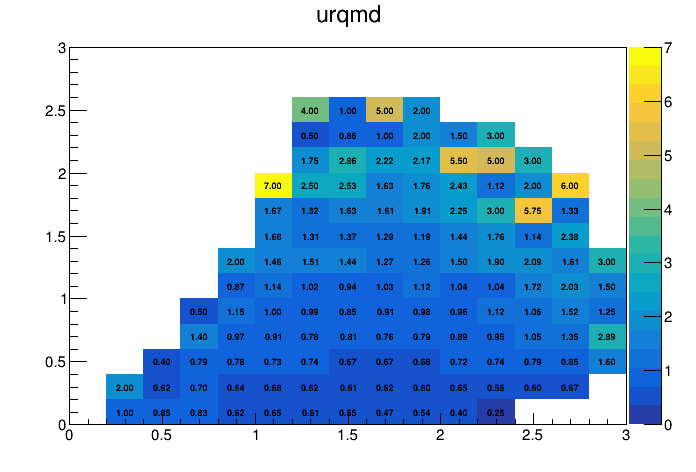

In [4]:
file = TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm/dcm_5.root")
MC_DCM=file.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")
file1 = ROOT.TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/urqmd/urqmd_5.root")
MC_URQMD=file1.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")

c1=ROOT.TCanvas("")
c1.Draw()
ratio = h2d_dcm.Divide(MC_DCM)
h2d_urqmd.Divide(h2d_dcm)
h2d_urqmd.Divide(MC_URQMD)
ROOT.gStyle.SetPaintTextFormat("4.2f")
h2d_urqmd.Draw("colz")
h2d_urqmd.SetStats (0)
h2d_urqmd.Draw("TEXT SAME")
c1.Print ("hists.png")

In [ ]:
df_clean1 =  tree_importer.tree_importer('/media/shahid/KINGSTON/dcm/c_20_pt_0.0_1.0_y_0.0_1.59.root','plain_tree',7)
df_clean2 = tree_importer.tree_importer('/media/shahid/KINGSTON/dcm/c_20_pt_0.0_1.0_y_1.59_9.0.root','plain_tree',7)
df_clean3 =  tree_importer.tree_importer('/media/shahid/KINGSTON/dcm/c_20_pt_1.0_9.0_y_0.0_1.59.root','plain_tree',7)
df_clean4 = tree_importer.tree_importer('/media/shahid/KINGSTON/dcm/c_20_pt_1.0_9.0_y_1.59_9.0.root','plain_tree',7)
dfs = [df_clean1, df_clean2, df_clean3,df_clean4]
df_clean = pd.concat(dfs)
del df_clean2, df_clean1, df_clean3,df_clean4, dfs

#df_clean.columns = new_labels
df_clean['issignal']=((df_clean['issignal']>0)*1)
df_clean["issignal"]=df_clean["issignal"].astype("int8")
#df_clean = df_clean[df_clean['issignal']>0]
#df_clean["issignal"].replace({1: 0, 2: 1}, inplace=True)
gc.collect()

In [ ]:
np.unique(df_clean.isnull().any( axis = 1 ))
np.unique(df_clean.isin( [np.inf, -np.inf]).any(axis =1))

In [ ]:
plot_labels=['$\chi^{2}_{geometrical}$', '$\chi^{2}_{primary\ \pi^-}$','$\chi^{2}_{primary\ proton}$', 'DCA (cm)', 'L/$\Delta$L','mass', '$p_{T}$', '$y_{LAB}$','issignal']

In [ ]:
def sig_bac_dist(df1):
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages('multipage_pdf.pdf') as pdf:
        df = df1.copy()
        for i in df1.columns:
            list =['chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosinepos', 'cosinetopo', 'distance', 'l', 'ldl', 'b', 'rapidity','mass', 'pT']
            if i in df1.columns:
                df[i]=np.log(df[i])
            plt.figure(figsize=(8, 6))
            with pd.option_context('mode.use_inf_as_na', True):
                df = df.dropna()
            bin1 = 300 
            plt.hist(df[df['issignal']==0][i],bins = bin1, color = 'blue',alpha = 0.3,label='Background')
            plt.hist(df[df['issignal']==1][i],bins = bin1, color = 'red',label='Primaries', alpha =0.3)
            plt.hist(df[df['issignal']==2][i],bins = bin1, color = 'green',label='Secondaries', alpha =0.3)
            plt.hist(df[df['issignal']>2][i],bins = bin1, color = 'yellow',label='>2', alpha =0.3)
            plt.yscale('log')
            #plt.grid()
            plt.ylabel('counts (log scale)', fontsize = 18)
            #plt.xlabel('$\chi^{2}_{geometrical}$', fontsize = 18)
            plt.legend(loc='upper right',fontsize=15)
            plt.tick_params(axis='both', which='major', labelsize=18)
            #ax.text(0, 1500, r'CBM Performance', fontsize=15)
            #ax.text(0, 500, r'URQMD, Au+Au @ 12 $A$GeV/$c$', fontsize=15)
            plt.title('URQMD, Au+Au @ 12 $A$GeV/$c$', fontsize=18)
            if i in list:
                plt.xlabel("log "+i, fontsize = 18)
            else:
                plt.xlabel(i, fontsize = 18)
            #plt.xlim([1.07,1.2])
            #plt.show()
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        del df



In [ ]:
sig_bac_dist(signal)

In [ ]:
for i in range (1,4):
    signal[signal['issignal']==i]['l'].hist(bins=1000, label=i, figsize=(12,8))
plt.legend(loc='upper right',fontsize=15)
plt.xlim(-10,100)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel('counts (log scale)', fontsize = 18)
plt.yscale('log')
plt.xlabel('Distance between PV and SV',fontsize = 18 )
plt.tight_layout()
plt.savefig("hists.png")


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
bin1 = 300 
range1=[0,4000]
plt.hist(df_urqmd_5k[df_urqmd_5k['issignal']==0]['ldl'],bins = bin1,range=range1, color = 'red',alpha = 0.3,label='Background')
plt.hist(df_urqmd_5k[df_urqmd_5k['issignal']==1]['ldl'],bins = bin1, range=range1, color = 'blue',label='Signal', alpha =0.3)
#plt.vlines(x=4,ymin=-1,ymax=10000, color='r', linestyle='-')
plt.yscale('log')
plt.grid()
plt.ylabel('counts (log scale)', fontsize = 18)
plt.xlabel(plot_labels[4], fontsize = 18)
plt.legend(loc='upper right',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.text(0.3, 15000, r'CBM Performance', fontsize=15)
ax.text(0.3, 5000, r'URQMD, Au+Au @ 12 $A$GeV/$c$', fontsize=15)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax.text(4, 10000, r'$PFSimple$', fontsize=20, color ='r')
#plt.xlim([0,20])
plt.show()
fig.tight_layout()
fig.savefig('hists.png')

## Renaming the columns

The above data frame object has some columns/features and for them at the very last column the true Monte Carlos information is available. This MC information tells us whether this reconstructed particle was originally produced as a decaying particle or not. So a value of 1 means that it is a true candidate and 0 means that it is not.

# Data Cleaning
Sometimes a data set contains entries which do not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. Ofcourse, we lose some data points but these outliers sometimes cause problems when we perform analysis. 

Since our experiment is a fixed target experiment so there are certain constraints which have to be applied on the data as well.

In [ ]:
def sig_bac(MC,data):
    signal_selected= MC[MC['issignal']]
    background_selected = data[(data['issignal'] == 0)
                    & ((data['mass'] > 1.07)
                    & (data['mass'] < 1.108) | (data['mass']>1.1227) 
                       & (data['mass'] < 1.3))].sample(n=3*(signal_selected.shape[0]))
    dfs = [signal_selected, background_selected]
    df_scaled = pd.concat(dfs)
    df_scaled = df_scaled.sample(frac=1)
    del dfs, signal_selected, background_selected
    return df_scaled

In [ ]:
plt.bar(df_)

In [ ]:
sig_bac(signal,df_clean_urqmd)

# Selecting Background and Signal
Our sample contains a lot of background (2178718) and somewhat signal candidates (36203). For analysis we will use a signal set of 4000 candidates and a background set of 12000 candidates. The background and signal candidates will be selected by using MC information.

In [ ]:
signal_selected= signal[(signal['mass']>1.1) & (signal['mass']<1.135)]
background_selected = df_clean_urqmd[(df_clean_urqmd['issignal'] == 0)
                & ((df_clean_urqmd['mass'] > 1.077)
                & (df_clean_urqmd['mass'] < 1.1) | (df_clean_urqmd['mass']>1.135) 
                   & (df_clean_urqmd['mass'] < 1.3))].sample(n=3*(signal_selected.shape[0]))
gc.collect()

#Let's combine signal and background
dfs = [signal_selected, background_selected]
df_scaled = pd.concat(dfs)

# Let's shuffle the rows randomly
df_scaled = df_scaled.sample(frac=1)
#del dfs, signal_selected, background_selected, signal
# Let's take a look at the top 10 entries of the df
df_scaled.iloc[0:10,:]
del signal, signal_selected, background_selected, dfs

In [ ]:
print(df_scaled.shape)
print(df_scaled[df_scaled['issignal']==1].shape)
print(df_scaled[df_scaled['issignal']==2].shape)
(5805268, 18)
(1056684, 18)
(394633, 18)

In [ ]:
sig_bac_dist(df_clean_urqmd)

y = 0.5 * (np.log(E+P/E-P))


https://cbm-wiki.gsi.de/foswiki/bin/view/PWG/CbmCollisionEnergies


y = 0.5 * (np.log((12+10)/(12-10)))


using this the rapidity is 3.1992 for Ebeam =12.04 and pbeam =12 and mid rapidity is y/2=  1.5996

In [ ]:
fig, axs = plt_sig_back(df_scaled)
fig.set_figheight(5)
fig.set_figwidth(8)
axs.text(1.13, 6000, r'DCM-QGSM-SMM', color = 'magenta',  fontsize=15)
axs.text(1.13, 4000, r'Au+Au @ 12 $A$GeV/$c$', color = 'magenta',  fontsize=15)
axs.text(1.13, 2000, r'URQMD, Au+Au @ 12 $A$GeV/$c$', fontsize=15)
fig.savefig("hists.pdf")

In [ ]:
new1 = signal_selected[signal_selected['issignal']==0]
new2 = signal_selected[signal_selected['issignal']==1]
new3 = new1.sample(n=1*(new2.shape[0]))
dfs = [new2, new3]
df_scaled = pd.concat(dfs)

In [ ]:
signal_selected.columns

# Creating Train and Test sets
To make machine learning algorithms more efficient on unseen data we divide our data into two sets. One set is for training the algorithm and the other is for testing the algorithm. If we don't do this then the algorithm can overfit and we will not capture the general trends in the data. 

In [ ]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
cuts = [ 'chi2geo', 'chi2primneg', 'chi2primpos', 'distance', 'ldl']
#cuts = [ 'chi2geo', 'chi2primneg', 'chi2primpos', 'chi2topo', 'cosinepos', 'cosinetopo', 'distance', 'l', 'ldl', 'b']


x = df_scaled[cuts].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(df_scaled['issignal'], dtype='int8')

In [ ]:
np.unique(y)

In [ ]:
sig_bac_dist(signal)

## Whole set

In [ ]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
x_whole = df_clean[cuts].copy()
# The MC information is saved in this y variable
y_whole = pd.DataFrame(df_clean['issignal'], dtype='int8')

In [ ]:
def KFPF_lambda_cuts(df):
    KFPF_lambda= df.copy()
    KFPF_lambda['new_signal']=0
    mask1 = (KFPF_lambda['chi2primpos'] > 18.4) & (KFPF_lambda['chi2primneg'] > 18.4)

    mask2 = (KFPF_lambda['ldl'] > 5) & (KFPF_lambda['distance'] < 1)

    mask3 = (KFPF_lambda['chi2geo'] < 3) 

    KFPF_lambda = KFPF_lambda[(mask1) & (mask2) & (mask3)] 

    #After all these cuts, what is left is considered as signal, so we replace all the values in the 'new_signal'
    # column by 1
    KFPF_lambda['new_signal'] = 1
    return KFPF_lambda

# KFPF

In [ ]:
#returns a new df 

#new_check_set=KFPF_lambda_cuts(df_original)
new_check_set=KFPF_lambda_cuts(df_clean_urqmd)
gc.collect()

<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>XGB Boost 
<br></p><br>

## Bayesian
In order to find the best parameters of XGB for our data we use Bayesian optimization. Grid search and and random search could also do the same job but bayesian is more time efficient. Stratify so that both train and test get the same ratio of signal to background.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324, stratify=y)
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_whole, label = y_whole)
dtest1=xgb.DMatrix(x_test, label = y_test)
gc.collect()

In [ ]:
x_whole_1 = df_clean_urqmd[cuts].copy()
# The MC information is saved in this y variable
y_whole_1 = pd.DataFrame(df_clean_urqmd['issignal'], dtype='int8')
dtest2 = xgb.DMatrix(x_whole_1, label = y_whole_1)

In [ ]:
gc.collect()

In [ ]:
x_whole_1 = df_clean_urqmd_bac[cuts].copy()
# The MC information is saved in this y variable
y_whole_1 = pd.DataFrame(df_clean_urqmd_bac['issignal'], dtype='int')
dtest2 = xgb.DMatrix(x_whole_1, label = y_whole_1)

In [ ]:
import time
starttime = time.time()
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate,scale_pos_weight):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,'scale_pos_weight':scale_pos_weight,
              'subsample': 0.8,
              'eval_metric': 'auc','tree_method':'hist','objective':'binary:logistic', 'nthread' : 7}
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]

xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0.01,1),
                                             'n_estimators':(100,500),'scale_pos_weight':(1,10)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')
cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")
#0.9983

### Hyper parameters

*subsample* [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.
range: (0,1]

*eta* [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]


*gamma* [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
range: [0,∞]


*alpha* [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.

*Lasso Regression* (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [ ]:
import time
starttime = time.time()


#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, alpha, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'n_estimators': n_estimators,
              'learning_rate':learning_rate,
              'subsample': 0.8, 
              'num_class':np.unique(dtrain.get_label()).shape[0], 
              'eval_metric': 'auc','tree_method':'hist', 'nthread' : 7}
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return  cv_result['test-auc-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'gamma': (0, 1),
                                            'alpha': (2,20),
                                             'learning_rate':(0.01,1),
                                             'n_estimators':(100,500)
                                            })
cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')
#0.9951


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log, argmax
import itertools

"""
A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its
discrimination threshold is varied. This function requires the true binary value and the target scores, which can either be probability estimates of
the positive class, confidence values, or binary decisions.
The function roc_auc_score computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

To find the best threshold which results more signal to background ratio for lambda candidates we use the parameter S0 called the approximate median significance
by the higgs boson  ML challenge (http://higgsml.lal.in2p3.fr/documentation,9.)
"""
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict)
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])

    roc_auc1=roc_auc_score(y_true1, y_predict1)
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])

    fig, ax = plt.subplots(figsize=(10, 6), dpi = 100)
    plt.plot(fpr, tpr, linewidth=3 ,linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
    #plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n AMS = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', s=80, color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n AMS = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize = 18)
    plt.legend(loc="lower right", fontsize = 18)
    plt.title('Receiver operating characteristic', fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    #axs.axis([-0.01, 1, 0.9, 1])
    fig.tight_layout()
    fig.savefig('hists.png')
    plt.show()
    return S0_best_threshold, S0_best_threshold1

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def AMS(y_true, y_predict, y_true1, y_predict1):
    roc_auc=roc_auc_score(y_true, y_predict, average='macro', multi_class='raise')
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    S0 = S0[~np.isnan(S0)]
    xi = argmax(S0)
    S0_best_threshold = (thresholds[xi])

    roc_auc1=roc_auc_score(y_true1, y_predict1, average='macro', multi_class='raise')
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    S01 = S01[~np.isnan(S01)]
    xi1 = argmax(S01)
    S0_best_threshold1 = (thresholds[xi1])

    fig, ax = plt.subplots(figsize=(12, 8), dpi = 100)
    plt.plot(fpr, tpr, linewidth=3 ,linestyle=':',color='darkorange',label='ROC curve train (area = %0.4f)' % roc_auc)
    plt.plot(fpr1, tpr1, color='green',label='ROC curve test (area = %0.4f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
    #plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n AMS = '+ "%.2f" % S0[xi])
    plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', s=80, color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n AMS = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize = 18)
    plt.legend(loc="lower right", fontsize = 18)
    plt.title('Receiver operating characteristic', fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    #axs.axis([-0.01, 1, 0.9, 1])
    fig.tight_layout()
    fig.savefig('hists.png')
    plt.show()
    return S0_best_threshold, S0_best_threshold1

In [ ]:
df_clean_urqmd_bac['xgb_preds'] = bst.predict(dtest2)

# XGB models

In [ ]:
import time
starttime = time.time()

max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'],
        'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 
         'objective':'binary:logistic','tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.train(param, dtrain, num_boost_round=20)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict(dtrain),  columns=["xgb_preds"])
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['issignal']=y_train['issignal']

#predictions on test set
bst_test = pd.DataFrame(data=bst.predict(dtest1),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['issignal']=y_test['issignal']

#ROC cures for the predictions on train and test sets
train_best, test_best = AMS(y_train, bst_train['xgb_preds'],y_test, bst_test['xgb_preds'])

#The first argument should be a data frame, the second a column in it, in the form 'preds'
preds_prob(bst_train,'xgb_preds', 'issignal',bst_test,'xgb_preds', 'issignal')

#Applying XGB on the 100k events data-set
df_clean['xgb_preds'] = bst.predict(dtest)
#preds_prob(df_clean,'xgb_preds', 'issignal','test')

df_clean_urqmd['xgb_preds'] = bst.predict(dtest2)
#del x_test, y_test, x_train, y_train, dtrain, dtest, x_whole, y_whole, x_whole_1, y_whole_1, dtest1, df_scaled
cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

In [ ]:
del x_test, y_test, x_train, y_train, dtrain, dtest, x_whole, y_whole, x_whole_1, y_whole_1, dtest1, df_scaled


In [ ]:
xgb_bo.max

In [ ]:
import time
starttime = time.time()

max_param = xgb_bo.max['params']
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'],
        'max_depth': int(round(max_param['max_depth'],0)), 'n_estimators': int(round(max_param['n_estimators'],0)), 
         'objective':'binary:logistic','tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['issignal']=y_train['issignal']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['issignal']=y_test['issignal']

#Applying XGB on the 100k events data-set
bst_test1 = pd.DataFrame(data=bst.predict_proba(x_whole))
df_clean['xgb_preds0'], df_clean['xgb_preds1'], df_clean['xgb_preds2']= bst_test1[0], bst_test1[1], bst_test1[2]
#preds_prob(df_clean,'xgb_preds', 'issignal','test')

bst_test2 = pd.DataFrame(data=bst.predict_proba(x_whole_1))
df_clean_urqmd['xgb_preds0'], df_clean_urqmd['xgb_preds1'], df_clean_urqmd['xgb_preds2']= bst_test2[0], bst_test2[1], bst_test2[2]


cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

In [ ]:
784/60

In [ ]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
#ax.figure.savefig("hits.png")

In [ ]:
plt.hist(df3_base['xgb_preds1'], bins=300, label=0)
plt.yscale('log')
plt.legend()
plt.show()

#plt.hist(bst_test['xgb_preds'], bins=300)
#plt.yscale('log')
bst_test['xgb_preds'].unique()

In [ ]:
plt.hist(df_clean['xgb_preds0'], bins=300, label=0)
plt.hist(df_clean['xgb_preds1'], bins=300, label=1)
plt.hist(df_clean['xgb_preds2'], bins=300, label=2)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.hist(df_clean_urqmd_bac['xgb_preds'], bins=300, label=0)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
fig, axs = preds_prob(bst_test,'xgb_preds0', 'issignal','test')
fig.savefig('hists.png')

In [ ]:
bst_test = pd.DataFrame(data=bst.predict(x_test),  columns=["xgb_preds"])
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['issignal']=y_test['issignal']

In [ ]:
bst_train

In [ ]:
def preds_prob(df,preds,true,df1,preds1, true1):
    fig, ax = plt.subplots(figsize=(12, 8))
    bins1=100
    TP = df[(df[true]==1)]
    TN = df[(df[true]==0)]
    
    plt.hist(TN[preds], bins=bins1,facecolor='blue',alpha = 0.3, label='background in train')
    plt.hist(TP[preds], bins=bins1,facecolor='red',alpha = 0.3, label='signal in train')
    
    
    TP1 = df1[(df1[true1]==1)]
    TN1 = df1[(df1[true1]==0)]
    
    hist1, bins1 = np.histogram(TN1[preds1], bins=bins1)
    err1 = np.sqrt(hist1)
    center1 = (bins1[:-1] + bins1[1:]) / 2
    plt.errorbar(center1, hist1, yerr=err1, fmt='o',
                 c='blue', label='background in test')
    
    hist, bins = np.histogram(TP1[preds1], bins=bins1)
    err = np.sqrt(hist)
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o',
                 c='red', label='signal in test')
    
   # ax.annotate('cut on probability', xy=(0, 90),  xycoords='data',xytext=(0.13,0.5), textcoords='axes fraction',
    #            fontsize=15,arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='top')
    

    
    if df[true].unique().shape[0]>2:
        TP2= df[df[true]>1]
        plt.hist(TP2[preds], bins=bins1,facecolor='green',alpha = 0.3, label='secondaries in train')
        TP2= df1[df1[true1]>1]
        hist2, bins2 = np.histogram(TP2[preds1], bins=bins1)
        center2 = (bins2[:-1] + bins2[1:]) / 2
        err2 = np.sqrt(hist2)
        plt.errorbar(center2, hist2,yerr=err2, fmt='o',c='green',label='secondaries in test')

    
    ax.set_yscale('log')
    ax.set_xlabel('Probability',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.legend(fontsize=18)
    fig.show()
    fig.tight_layout()
    return fig, ax
    #fig.savefig('Lambda_XGB_prediction_0.jpg')

In [ ]:
import matplotlib as mpl
h=plt.hist2d(df_clean['rapidity'],df_clean['pT'], bins=15*25, norm=mpl.colors.LogNorm())
plt.xlabel('$y_{Lab}$',fontsize=15)
plt.ylabel("pT",fontsize=15)
plt.tight_layout()
plt.savefig('hists.png')

In [ ]:
bst_train1 = bst_train[(bst_train[0]<0.35) ]
bst_test1 = bst_test[(bst_test[0]<0.35) ]

In [ ]:
df3_base = df_clean[(df_clean['rapidity']<0.5) & (df_clean['pT']<0.5) ]

In [ ]:
print(df3_base[df3_base['issignal']==0].shape[0]/529256.0)
print(df3_base[df3_base['issignal']==1].shape[0]/101)
print(df3_base[df3_base['issignal']>1].shape[0]/35)

In [ ]:
#preds_prob(bst_train,0, 'issignal',bst_test,0, 'issignal')
#for i in ['xgb_preds0','xgb_preds1','xgb_preds2']:
for i in ['xgb_preds0']:
    fig, ax = preds_prob(df_clean_urqmd,i, 'issignal',df_clean_urqmd,i, 'issignal')
    plt.legend(["back","prim","second"],fontsize=18)
    fig.savefig("hists"+str(i)+".png")

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt, log, argmax
import itertools
def AMS(y_true, y_predict, y_true1, y_predict1):
    #roc_auc=roc_auc_score(y_true, y_predict, multi_class='ovo', average='weighted')
    fpr, tpr, thresholds = roc_curve(y_true, y_predict,drop_intermediate=False ,pos_label=1)
    #S0 = sqrt(2 * ((tpr + fpr) * log((1 + tpr/fpr)) - tpr))
    #S0 = S0[~np.isnan(S0)]
    #xi = argmax(S0)
    #S0_best_threshold = (thresholds[xi])

    #roc_auc1=roc_auc_score(y_true1, y_predict1, multi_class='ovo', average='weighted')
    fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_predict1,drop_intermediate=False ,pos_label=1)
    #S01 = sqrt(2 * ((tpr1 + fpr1) * log((1 + tpr1/fpr1)) - tpr1))
    #S01 = S01[~np.isnan(S01)]
    #xi1 = argmax(S01)
    #S0_best_threshold1 = (thresholds[xi1])

    fig, ax = plt.subplots(figsize=(12, 8), dpi = 100)
    plt.plot(fpr, tpr, linewidth=3 ,linestyle=':',color='darkorange')
    plt.plot(fpr1, tpr1, color='green')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
    #plt.scatter(fpr[xi], tpr[xi], marker='o', color='black', label= 'Best Threshold train set = '+"%.4f" % S0_best_threshold +'\n AMS = '+ "%.2f" % S0[xi])
    #plt.scatter(fpr1[xi1], tpr1[xi1], marker='o', s=80, color='blue', label= 'Best Threshold test set = '+"%.4f" % S0_best_threshold1 +'\n AMS = '+ "%.2f" % S01[xi1])
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize = 18)
    plt.legend(loc="lower right", fontsize = 18)
    plt.title('Receiver operating characteristic', fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.02])
    #axs.axis([-0.01, 1, 0.9, 1])
    fig.tight_layout()
    fig.savefig('hists.png')
    plt.show()
    #return S0_best_threshold, S0_best_threshold1

In [ ]:
train_best, test_best = AMS(y_train, bst_train[1],y_test, bst_test[1])

In [ ]:
# The following function will display the inavriant mass histogram of the original 10k event set along with the mass histoigram after we apply a cut
# on the probability prediction of xgb
def cut_visualization(df, variable,cut, range1=(1.09, 1.15), bins1= 300 ):
    mask1 = df[variable]>cut
    df3=df[mask1]
    
    fig, ax2 = plt.subplots(figsize=(8, 6), dpi = 300)
    color = 'tab:blue'
    ax2.hist(df['mass'],bins = bins1, range=range1, facecolor='blue' ,alpha = 0.35, label='no selection')
    ax2.set_ylabel('Counts', fontsize = 15, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend( fontsize = 15, loc=(0.55, 0.55))
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
    
    
    
    color = 'tab:red'
    ax1 = ax2.twinx()
    ax1.hist(df3['mass'], bins = bins1, range=range1, facecolor='red',alpha = 0.35, label="XGB  > %.2f"%cut+'')
    ax1.set_xlabel('Mass in GeV', fontsize = 15)
    ax1.set_ylabel('Counts ', fontsize = 15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.legend( fontsize = 15,loc=(0.55, 0.47) )

    #plt.title("The original sample's Invariant Mass along with mass after selection of XGB", fontsize = 15)
    plt.text(1.09, 6000, 'CBM Performance', fontsize=15)
    plt.text(1.09, 5500, 'URQMD, Au+Au$', fontsize=15)
    plt.text(1.09, 5000, '@ 12A GeV/$c$', fontsize=15)
    plt.text(1.13, 6000, '$\Lambda$ hyperons', fontsize=15)
    #plt.text(0.02, 0.1, r'cut > %.4f'%cut, fontsize=15)
    plt.show()
    fig.tight_layout()
    fig.savefig("Fig2_Lambda_XGB_selection.png")

In [ ]:
cut_visualization(df_clean_urqmd,'xgb_preds',test_best)

In [ ]:
range1= (1.11, 1.122)
fig, axs = plt.subplots(figsize=(12, 8))
df_clean_urqmd[(df_clean_urqmd['xgb_preds']>0.1) ]['mass'].plot.hist(bins = bins1, range=range1, histtype='step', Fill=False,sharey=True, label='BDT > 0.1 XGB selected $\Lambda$s')
df_clean_urqmd[(df_clean_urqmd['xgb_preds']>0.5) ]['mass'].plot.hist(bins = bins1, range=range1, histtype='step', Fill=False,sharey=True, label='BDT > 0.5 XGB selected $\Lambda$s')
df_clean_urqmd[(df_clean_urqmd['xgb_preds']>0.8) ]['mass'].plot.hist(bins = bins1, range=range1, histtype='step', Fill=False,sharey=True, label='BDT > 0.8 XGB selected $\Lambda$s')
df_clean_urqmd[(df_clean_urqmd['xgb_preds']>0.9) ]['mass'].plot.hist(bins = bins1, range=range1, color = 'red', histtype='step', Fill=False,sharey=True, label='BDT > 0.9 XGB selected $\Lambda$s')

axs.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
plt.legend( fontsize = 18, loc='upper right')
axs.tick_params(labelsize=18)
fig.tight_layout()

fig.savefig("whole_sample_invmass_with_ML.png")


In [ ]:
cut3 = 0.93
df3_base=df_clean_urqmd[(df_clean_urqmd['xgb_preds']>cut3) ]
#df3_base=df3_base[df3_base['xgb_preds1']>0.45]
#df3_base=df3_base[(df3_base['xgb_preds2']<0.45)&(df3_base['xgb_preds2']>0.15)]
fig, axs = plt.subplots(figsize=(12, 8))

range1= (1.105, 1.14)
bins1 = 150

#xgb

#issignal has 0,1,2 . So we convert all signals above zero to 1



df3_base['mass'].plot.hist(bins = bins1, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True, label='XGB selected $\Lambda$s')
#df3_base[df3_base['issignal']==1]['mass'].plot.hist(bins = 300, range=range1,facecolor='blue',alpha = 0.3,grid=True,sharey=True, '\n True positives = \n (MC =1)\n signal in \n the distribution')
#df3_base[df3_base['issignal']==1]['mass'].plot.hist(bins = bins1, range=range1,facecolor='magenta',alpha = 0.3,grid=True,sharey=True )
df3_base[df3_base['issignal']==0]['mass'].plot.hist(bins = bins1, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True, label ='\n False positives = \n (MC =0)\n background in \n the distribution')

plt.legend( fontsize = 18, loc='upper right')
#plt.rcParams["legend.loc"] = 'upper right'
plt.title("XGB selected $\Lambda$ candidates with a cut of %.3f "%cut3 +"on the XGB back probability distribution", fontsize = 18)
axs.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
#axs.text(1.123, 4000, 'CBM Performance', fontsize=18)
#axs.text(1.123, 3500, 'URQMD, Au+Au @ 12A GeV/$c$', fontsize=18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")
del df3_base

In [ ]:
sig_bac_dist(df3_base)

In [ ]:
df3_base[(df3_base['issignal']==0)&(df3_base['chi2topo']<50)]['chi2topo'].hist(bins =100)
df3_base[(df3_base['issignal']==1) &(df3_base['chi2topo']<50)]['chi2topo'].hist(bins =100)
plt.xlim(0,15)

In [ ]:
print(df3_base[(df3_base['issignal']==0)&(df3_base['chi2topo']<5)].shape[0])
print(df3_base[(df3_base['issignal']==1) &(df3_base['chi2topo']<5)].shape[0])
print(df3_base[df3_base['issignal']>1].shape[0])



In [ ]:
df3_base['cosinetopo'].hist(bins=100)

In [ ]:
cut3 = 0.9
#mask1 = df_clean_urqmd['xgb_preds']>cut3
#df3_base0=df_clean_urqmd[mask1]
#df3_base = pd.concat([df_clean_urqmd,df3_base0]).drop_duplicates(keep=False)
mask1 = df_clean_urqmd['xgb_preds']>cut3
df3_base=df_clean_urqmd[mask1]
fig, axs = plt.subplots(figsize=(12, 8))

range1= (1.105, 1.14)
bins1 = 150

df3_base['mass'].plot.hist(bins = bins1, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True, label='XGB selected $\Lambda$s')
df3_base[df3_base['issignal']==0]['mass'].plot.hist(bins = bins1, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True, label ='\n False positives = \n (MC =0)\n background in \n the distribution')
#df3_base[df3_base['issignal']==1]['mass'].plot.hist(bins = 300, range=range1,facecolor='blue',alpha = 0.3,grid=True,sharey=True, label ='\n True positives = \n (MC =1)\n signal in \n the distribution')

plt.legend( fontsize = 18, loc='upper right')
plt.title("XGB selected $\Lambda$ candidates with a cut of %.3f "%cut3 +"on the XGB probability distribution", fontsize = 18)
axs.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
axs.text(1.123, 5000, 'CBM Performance', fontsize=18)
axs.text(1.123, 4000, 'URQMD, Au+Au @ 12A GeV/$c$', fontsize=18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
cut3 = 0.9
mask1 = df_clean_urqmd['xgb_preds']>cut3
df3_base=df_clean_urqmd[mask1]
fig, axs = plt.subplots(figsize=(12, 8))

range1= (1.105, 1.14)
bins1 = 150

df3_base['mass'].plot.hist(bins = bins1, range=range1, facecolor='red',alpha = 0.3,grid=True,sharey=True, label='XGB selected $\Lambda$s')
df3_base[df3_base['issignal']==0]['mass'].plot.hist(bins = bins1, range=range1,facecolor='green',alpha = 0.3,grid=True,sharey=True, label ='\n False positives = \n (MC =0)\n background in \n the distribution')

plt.legend( fontsize = 18, loc='upper right')
plt.title("XGB selected $K_{s}$ candidates with a cut of %.3f "%cut3 +"on the XGB probability distribution", fontsize = 18)
axs.set_xlabel("Mass (GeV/${c^2}$)", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
axs.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
def efficiency_plot_mass(df,signal_column, predictions_column, cut_value, range_min, range_max, bin1):
    from matplotlib import gridspec
    x_min, x_max = range_min , range_max
    range1= (x_min, x_max)

    fig, axs = plt.subplots(2, 1,figsize=(10,10), sharex=True, constrained_layout=True,  gridspec_kw={'width_ratios': [10],
                               'height_ratios': [8,4]})
    
    ns, bins, patches=axs[0].hist((df[(df[predictions_column]>cut_value) & (df[signal_column]==1)]['mass']),bins = bin1,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
    ns1, bins1, patches1=axs[0].hist((df[df[signal_column]==1]['mass']),bins = bin1,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)

    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs[0].set_ylabel("log(counts)", fontsize = 18)
    axs[0].legend(('XGBoost TP','MC TP'), fontsize = 18, loc='upper right')
    axs[0].tick_params(axis='both', which='major', labelsize=18)
    axs[0].set_yscale('log')

    err = np.std(ns)
    err1 = np.std(ns1)
    corr_ns_ns1 = np.corrcoef(ns,ns1)[[0],[1]][0]
    err_dif = (ns / ns1) * (np.sqrt( ((err/ns)**2) + ((err1/ns1)**2)
                                      -2* ((corr_ns_ns1*err*err1)/(ns*ns1))))


    axs[1].hlines(y=1, xmin=x_min, xmax=x_max, colors='black', linestyles='dashed', label='')
    center = (bins[:-1] + bins[1:]) / 2
    axs[1].errorbar(center,  ns / ns1, yerr=err_dif,  fmt='o',
                     c='Blue', label='Background in predictions')


    plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
    axs[1].set_ylabel("XGB / MC", fontsize = 18)
    axs[1].grid()
    axs[1].tick_params(axis='both', which='major', labelsize=18)
    fig.show()
    fig.tight_layout()
    return fig, axs

In [ ]:
efficiency_plot_mass(df_clean_urqmd,'issignal', 'xgb_preds', 0.96, 1.112, 1.12, 40)

In [ ]:
def pT_vs_rapidity(df, var_xaxis , var_yaxis , range_var_xaxis, range_var_yaxis,signal_column, predictions_column, cut_value):
    import matplotlib as mpl
    fig, axs = plt.subplots(figsize=(6, 4),dpi = 300)
    h=plt.hist2d(df[(df[predictions_column]>cut_value) & (df[signal_column]==1)][var_xaxis],
                                 df[(df[predictions_column]>cut_value) & (df[signal_column]==1)][var_yaxis],
                                 range=[range_var_xaxis,range_var_yaxis], bins=np.arange(0,17)*0.2+0, norm=mpl.colors.LogNorm())
    cbar = plt.colorbar()
    h=plt.hist2d(df[df[signal_column]==1][var_xaxis],df[df[signal_column]==1][var_yaxis],range=[range_var_xaxis,range_var_yaxis], bins=np.arange(0,17)*0.2+0, norm=mpl.colors.LogNorm())
    axs.hist2d(h[0],h[1])
    #v1 = np.linspace(0, h[0].max(), 4, endpoint=True)
    #cbar = fig.colorbar(h[3], ticks = v1 )
    #cbar.set_ticks([h[0].min(),(h[0].max()-h[0].min())/2,h[0].max()])
    #cbar.set_ticklabels([h[0].min(),(h[0].max()-h[0].min())/2,h[0].max()])
    
    #v1 = np.linspace(Z.min(), Z.max(), 8, endpoint=True)
    #cbar=plt.colorbar(ticks=v1)              # the mystery step ???????????
    #cbar.ax.set_yticklabels([ '0', '1784', '3568', '5353']) # add the labels
    

    
    #plt.vlines(x=1.59,ymin=-1,ymax=2.4, color='r', linestyle='-')
    #plt.hlines(y=bins4[1], xmin=bins0[3], xmax=3.162, colors='b', linestyles='solid', label='')
    #plt.hlines(y=bins4[2], xmin=bins0[3], xmax=3.162, colors='b', linestyles='solid', label='')

    #plt.hlines(y=0.4, xmin=-0.1, xmax=df[var_xaxis].max(), colors='b', linestyles='solid', label='')
    #plt.hlines(y=0.2, xmin=-0.1, xmax=1.5996, colors='b', linestyles='solid', label='')
    #plt.hlines(y=0.9, xmin=-0.1, xmax=3.5, colors='b', linestyles='solid', label='')
    plt.xlabel('$y_{Lab}$', fontsize=20)
    plt.ylabel('$p_{T}$ (GeV/$c$)', fontsize=18)
    axs.text(0.02, 3, r'CBM Performance', fontsize=15)
    axs.text(0.02, 2.8, r'URQMD, Au+Au @ 12 $A$GeV/$c$', fontsize=15, color ='r')
    axs.text(1.2, 0.6, r'$y_{CM}$', fontsize=20, color ='r')
    axs.tick_params(axis='both', which='major', labelsize=18)
    axs.grid(b=True, animated=True )
    axs.set_xticks(np.arange(0,17)*0.2+0)
    axs.set_xticklabels(['0' ,'' ,'' ,'0.6','','', '1.2','','', '1.8','' ,'' ,'2.4','','' ,'3' , ''])
    axs.set_yticks(np.arange(0,16)*0.2+0)
    axs.set_yticklabels(['0' ,'' ,'' ,'0.6','','', '1.2','','', '1.8','' ,'' ,'2.4','','' ,'3' , ''])
    #plt.title("  y-$p_{T}$ plot for signal candidates (MC=1) with a cut = %.2f"%0.95,  fontsize=18)
    #plt.grid(which='both', ydata =yy)
    plt.show()
    
    
    fig.tight_layout()
    fig.savefig("/home/shahid/cbmsoft/Cut_optimization/uncut_data/pT_vs_rapidity.png")
    return h

In [ ]:
import matplotlib as mpl
h=plt.hist2d(df_clean_urqmd['rapidity'],df_clean_urqmd['pT'],range=[3,3], bins=np.arange(0,17)*0.2+0, norm=mpl.colors.LogNorm())

In [ ]:
h[0]

In [ ]:
pT_vs_rapidity(df_clean_urqmd,'rapidity','pT',3,3, 'issignal','xgb_preds', 0.96)

In [ ]:
df3_base[df3_base['issignal']==2].shape

In [ ]:
[[ 97718      0]
 [186553      0]]

In [ ]:
(32947+76208)/97718

## Confusion Matrix

By definition a confusion matrix $C$ is such that $C_{i, j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

Thus in binary classification, the count of true positives is $C_{0,0}$, false positives is $C_{1,0}$, true negatives is $C_{1,1}$ and false negatives is $C_{0,1}$.

The following function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.

In [ ]:
import time
starttime = time.time()
cut3 = test_best
df_clean['xgb_preds'] = ((df_clean['xgb_preds']>cut3)*1)
cnf_matrix = confusion_matrix(df_clean['issignal'], df_clean['xgb_preds'], labels=[2,1,0])
#cnf_matrix = confusion_matrix(new_check_set['issignal'], new_check_set['new_signal'], labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=['secondaries','primaries','background'], title='Confusion Matrix for XGB for cut > '+str(cut3))
plt.savefig('confusion_matrix_extreme_gradient_boosting_whole_data.png')
cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

In [ ]:
import seaborn as sn

df_cm = pd.DataFrame(cnf_matrix, ['secondaries','primaries','background'], ['secondaries','primaries','background'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
Confusion matrix, without normalization
[[       0    37483     3232]
 [       0   101579     8955]
 [       0   437569 45809781]]

In [ ]:
(cnf_matrix[[0]][0][1])/ (cnf_matrix[[0]][0][0]+cnf_matrix[[0]][0][1])

In [ ]:
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
ax.figure.savefig("hits.png")

In [ ]:
xgb.plot_tree(bst,num_trees=2)
plt.rcParams['figure.figsize'] = [80, 160]
plt.rcParams['figure.dpi']=300
#plt.show()
plt.savefig("hists.pdf")

In [ ]:
bst.to_graphviz(xg_reg, fmap='', num_trees=0, rankdir=None, yes_color=None, no_color=None, condition_node_params=None, leaf_node_params=None)

# Cut visualization

In [ ]:
from matplotlib import gridspec

range1= (1.08, 1.15)


fig, axs = plt.subplots(2, 1,figsize=(10,10), sharex=True, constrained_layout=True,  gridspec_kw={'width_ratios': [10],
                           'height_ratios': [8,4]})


ns, bins, patches=axs[0].hist((df3_base['mass']),bins = 50,histtype='step', range=range1,Fill=False, color='red', facecolor='red', linewidth=2)
ns1, bins1, patches1=axs[0].hist((new_check_set['mass']),bins = 50,histtype='step', Fill=False, range=range1,facecolor='blue',linewidth=2)
#plt.xlabel("Mass in GeV", fontsize = 15)
axs[0].set_ylabel("counts", fontsize = 18)
#axs[0].grid()
axs[0].legend(('XGBoost','KFPF '), fontsize = 18, loc='upper right')


axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].set_yscale('log')

axs[1].hlines(y=1, xmin=1.112, xmax=1.12, colors='black', linestyles='dashed', label='')
center = (bins[:-1] + bins[1:]) / 2

err = np.std(ns)
err1 = np.std(ns1)
corr_ns_ns1 = np.corrcoef(ns,ns1)[[0],[1]][0]
err_dif = (ns / ns1) * (np.sqrt( ((err/ns)**2) + ((err1/ns1)**2)
                                      -2* ((corr_ns_ns1*err*err1)/(ns*ns1))))
axs[1].errorbar(center,  ns / ns1,   fmt='o',
                 c='Blue', label='Background in predictions')


    
    
plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 18)
axs[1].set_ylabel("XGB / KFPF", fontsize = 18)
#axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=18)

fig.show()
fig.tight_layout()
fig.savefig("whole_sample_invmass_with_ML.png")

In [ ]:
df3_base[df3_base['issignal']>0].shape

In [ ]:
fig5 = plt.figure(constrained_layout=True)
widths = [2, 3, 1.5]
heights = [1, 3, 2]
spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                          height_ratios=heights)
fig5.show()

In [ ]:
del dtest, dtrain, dtest1, df_scaled, x, y, x_whole, y_whole, x_train, x_test, y_train, y_test
gc.collect()

In [ ]:
dcm_100k = df_clean.copy()
del df_clean

In [ ]:
#bdt cut 0.7
df0 = df3_base
df0 = df0[(df0['mass']>1.07)&(df0['mass']<1.3)]
df0 = df0[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
#bdt cut 0.8
df1 = df3_base
df1 = df1[(df1['mass']>1.07)&(df1['mass']<1.3)]
df1 = df1[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
#bdt cut 0.9
df2 = df3_base
df2 = df2[(df2['mass']>1.07)&(df2['mass']<1.3)]
df2 = df2[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
#0.92
df3 = df3_base
df3 = df3[(df3['mass']>1.07)&(df3['mass']<1.3)]
df3 = df3[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
#test_best
df4 = df3_base
df4 = df4[(df4['mass']>1.07)&(df4['mass']<1.3)]
df4 = df4[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
#test_best
df4_urqmd = df3_base
df4_urqmd = df4_urqmd[(df4_urqmd['mass']>1.07)&(df4_urqmd['mass']<1.3)]
df4_urqmd = df4_urqmd[['rapidity', 'mass', 'pT', 'issignal']]
del df3_base

In [ ]:
df4=df4[df4['issignal']==1]
#df4 = df4[['rapidity', 'mass', 'pT']]

In [ ]:
del df_clean

## Curve Fitting

# PyRoot

In [ ]:
import sys, ROOT
from ROOT import TF1, TCanvas,TMath, TColor

class Linear:
    def __call__( self, x, par ):
        return par[0] + x[0]*par[1]

class lorenztian:
    def _call_(self, x, p):
        return 0.5*p[0]*p[1] /( ((x[0]-p[2])**2) + ((0.5 * (p[1])**2))) 

class gaus:
    def _call_(self, x ,p):
        return p[0]*np.exp(-0.5*((x[0]-p[2])/p[1])**2)

In [ ]:
import math
def truncate(number, decimals=2):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor


def background_selector(df):
    df1 = df[(df['mass']<1.108)]
    df2 = df[df['mass']>1.13]
    df3 = pd.concat([df1, df2])
    return df3['mass'] 

In [ ]:
truncate(0.39)

In [ ]:
#percentile binning
#df0 = df3_base
#df = df0[(df0['mass']>1.07)&(df0['mass']<1.3)]
df = df4
out0, bins0 =pd.qcut(df['rapidity'], q=4, retbins=1)
lowest_rapidity = df[df['rapidity']<bins0[1]]
low_rapidity = df[(df['rapidity']>bins0[1])&(df['rapidity']<bins0[2])]
mid_rapidity = df[(df['rapidity']>bins0[2])&(df['rapidity']<bins0[3])]
high_rapidity = df[(df['rapidity']>bins0[3])]
    
out1, bins1 =pd.qcut(lowest_rapidity['pT'], q=3, retbins=1)
low_pT_lowest_rapidity = lowest_rapidity[lowest_rapidity['pT']<bins1[1]]
mid_pT_lowest_rapidity = lowest_rapidity[(lowest_rapidity['pT']>bins1[1]) & (lowest_rapidity['pT']<bins1[2])]
high_pT_lowest_rapidity =lowest_rapidity[(lowest_rapidity['pT']>bins1[2])]

out2, bins2 =pd.qcut(low_rapidity['pT'], q=3, retbins=1)
low_pT_low_rapidity = low_rapidity[low_rapidity['pT']<bins2[1]]
mid_pT_low_rapidity = low_rapidity[(low_rapidity['pT']>bins2[1]) & (low_rapidity['pT']<bins2[2])]
high_pT_low_rapidity= low_rapidity[(low_rapidity['pT']>bins2[2])]
    
out3, bins3 =pd.qcut(mid_rapidity['pT'], q=3, retbins=1)
low_pT_mid_rapidity = mid_rapidity[mid_rapidity['pT']<bins3[1]]
mid_pT_mid_rapidity = mid_rapidity[(mid_rapidity['pT']>bins3[1]) & (mid_rapidity['pT']<bins3[2])]
high_pT_mid_rapidity=mid_rapidity[(mid_rapidity['pT']>bins3[2])]
    
out4, bins4 =pd.qcut(high_rapidity['pT'], q=3, retbins=1)
low_pT_high_rapidity = high_rapidity[high_rapidity['pT']<bins4[1]]
mid_pT_high_rapidity = high_rapidity[(high_rapidity['pT']>bins4[1]) & (high_rapidity['pT']<bins4[2])]
high_pT_high_rapidity=high_rapidity[(high_rapidity['pT']>bins4[2])]

#del out0, lowest_rapidity, mid_rapidity, high_rapidity, out1, out2, out3, out4, df

In [ ]:
def background_selector(df):
    df1 = df[(df['mass']<1.108)]
    df2 = df[df['mass']>1.13]
    df3 = pd.concat([df1, df2])
    return df3['mass'] 

list1 = [low_pT_lowest_rapidity, mid_pT_lowest_rapidity, high_pT_lowest_rapidity, low_pT_low_rapidity,
         mid_pT_low_rapidity, high_pT_low_rapidity, low_pT_mid_rapidity, mid_pT_mid_rapidity,
        high_pT_mid_rapidity, low_pT_high_rapidity, mid_pT_high_rapidity, high_pT_high_rapidity]

In [ ]:
#df4['mass'].describe()[1]-1.2*(df4['mass'].describe()[2])+0.2* (df4['mass'].describe()[2])
df4['mass'].describe()[1]+1.2*(df4['mass'].describe()[2])+0.2* (df4['mass'].describe()[2])

## Lorentzian
Lorenztian with second chebyshev 2nd order polynom

The describe of BDT score > 70 shows that the sigma of the data mean is at 1.178052 with an std of 0.059818. So 1.55sigma below the mean is 1.0883250000000002 and 1.55 sigma above the mean is 1.267779. So let's choose 1.55, 1.5 and 1.45 below the mean and vice versa.

In [ ]:
pol2 = TF1("fb","[0]+[1]*x+[2]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
pol3 = TF1("fb","[0]+[1]*x+[2]*x*x+[3]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
one_var_pol2=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
one_var_pol3=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])

In [ ]:
#lorentzian + second order pol
lorentzian_pol2 = []
pt_min=[]
y_min = []
#lorentzian_3rd_order_pol = []


df = df4_urqmd


mass_range_min = [df['mass'].describe()[1]-1.2*(df['mass'].describe()[2])]
fit_limit_low=[0,0.1* (df['mass'].describe()[2]),   0.2* (df['mass'].describe()[2]),
               df['mass'].describe()[1]+1.2*(df['mass'].describe()[2]),
               df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.1* (df['mass'].describe()[2]),
                df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.2* (df['mass'].describe()[2])]

y_bin_low = -0.2
y_bin_up =0.0
for i in range(0,15,1):
    y_bin_low = truncate(y_bin_low + 0.2)
    y_bin_up = truncate(y_bin_up+0.2)
    df_y = df[(df['rapidity']>y_bin_low) & (df['rapidity']<y_bin_up)]
    
    pt_bin_low =-0.2
    pt_bin_up =0
    for i in range(0,15,1):
        pt_bin_low = truncate(pt_bin_low+0.2)
        pt_bin_up = truncate(pt_bin_up+0.2)
        df_pt = df_y[(df_y['pT']>pt_bin_low) & (df_y['pT']<pt_bin_up)]
        mc_counts = df_pt[df_pt['issignal']>0].shape[0]
        
        for mm in mass_range_min:
            for mmm in range(0,3,1):
                
                #canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
                #canvas.Draw()
                #canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
                binning = [40,70,100,130]
                for b in binning:
                    tot_sig_3_sigma = 0
                    tot_bac_3_sigma = 0
                    tot_sig_3_point_5_sigma = 0
                    tot_bac_3_point_5_sigma = 0
                    tot_sig_2_point_5_sigma = 0
                    tot_bac_2_point_5_sigma = 0
                    tot_sig_2_sigma = 0


                    #step 0
                    if df_pt.shape[0]>500:
                        data0 = background_selector(df_pt)
                        h0 = ROOT.TH1F("Background","Background without peak",b,mm,fit_limit_low[5])
                        for i in range(0,data0.shape[0]):
                            h0.Fill(data0.iloc[i])
                        fb = TF1("fb","[0]+[1]*x+[2]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fb.SetParameters(0,0,0);
                        #fb =TF1("fb","[0]+[1]*x+[2]*x*x+[3]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #fb.SetParameters(0,0,0,0);
                        h0.Fit(fb,"RIEMQN");
                        par = fb.GetParameters()
                        #Step 1
                        data = df_pt['mass']
                        
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        f1.SetParameters(1,par[0], par[1], par[2]);
                        #f1=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f1.SetParameters(1,par[0], par[1], par[2],par[3]);
                        h1.Fit(f1,"RNIQ");
                        par1 = f1.GetParameters()

                        #canvas .Clear ()
                        #pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
                        #pad1 . Draw ()
                        #pad1 . cd ()
                        #pad1. Clear()





                #step 2
                        f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3]);
                        #f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x+[6]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2.SetNpx(100000);
                        #f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3],par1[4]);
                        #f2.SetLineColor(ROOT.kRed)
                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNIRQ"))
                        par2 = f2.GetParameters()

                        fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #fs.SetNpx(100000);
                        #fs.SetLineColor(ROOT.kGreen)
                        #fb.SetLineStyle(4)
                        #fb.SetLineColor(ROOT.kBlue)
                        #fb.SetNpx(100000);
                        fs.SetParameters(par2[0],par2[1],par2[2]);
                        fb.SetParameters(par2[3],par2[4],par2[5]);
                        #fb.SetParameters(par2[3],par2[4],par2[5],par2[6]);


                        #h1.SetTitleOffset(-1)
                        #h1.SetFillStyle(3003);
                        #h1.SetLineWidth(2)
                        #h1.SetStats (0)
                        #h1.SetYTitle("Entries")
                        #h1.SetLineColor(ROOT.kBlack)
                        h2 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h3 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        #h3.SetLineWidth(2)
                        #h3.SetStats (0)
                        #h3.GetXaxis().SetTitle("Mass (GeV/c^2)")

                        #h1.Draw("pe")
                        #fs.Draw("SAME")
                        #fb.Draw("SAME")
                        #f2.Draw("SAME")

                        bin1 = h1.FindBin(fit_limit_low[mmm]+mm);
                        bin2 = h1.FindBin(fit_limit_low[mmm+3]);
                        for i in range(bin1,bin2):
                            f_value= f2.Eval(h1.GetBinCenter(i));
                            t_value = h1.GetBinContent(i)
                            h2.SetBinContent(i,f_value)
                            if (h1.GetBinError(i) > 0):
                                h3.SetBinContent(i,(t_value-f_value)/h1.GetBinError(i))

                        #h2.Sumw2()

                        integral_min = par2[2] - (TMath.Abs(3*par2[1]));
                        integral_max = par2[2] + (TMath.Abs(3*par2[1]));
                        binwidth = h1.GetXaxis().GetBinWidth(1);
                        #tot = f2.Integral(integral_min,integral_max)/binwidth;
                        #sigma_integral = f2.IntegralError(integral_min,integral_max);

                        signal_under_peak = (fs.Integral(integral_min,integral_max)/binwidth);
                        if signal_under_peak>0:
                            tot_sig_3_sigma= tot_sig_3_sigma+signal_under_peak                
                        #sigma_signal_under_peak = fs.IntegralError(integral_min,integral_max);
                        #man_sigma_signal_under_peak = TMath.Sqrt(signal_under_peak)
                        if sigma_signal_under_peak!=0:
                            print("Integral errors ",sigma_signal_under_peak)

                        
                        backgnd_under_peak = (fb.Integral(integral_min,integral_max)/binwidth)
                        #if backgnd_under_peak<0:
                            #print('Negative background')

                        Significance = signal_under_peak/TMath.Sqrt(tot);

                        signal_under_peak_3_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        #bac_under_peak_3_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        if signal_under_peak_3_point_5_sigma>0:
                            tot_sig_3_point_5_sigma= tot_sig_3_point_5_sigma+signal_under_peak_3_point_5_sigma                
                        #tot_bac_3_point_5_sigma = tot_bac_3_point_5_sigma + bac_under_peak_3_point_5_sigma

                        #sigma_signal_under_peak_3_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])));
                        #man_sigma_signal_under_peak_3_point_5_sigma = TMath.Sqrt(signal_under_peak_3_point_5_sigma)

                        signal_under_peak_2_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        #bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        if signal_under_peak_2_point_5_sigma>0:
                            tot_sig_2_point_5_sigma = tot_sig_2_point_5_sigma+signal_under_peak_2_point_5_sigma
                        #tot_bac_2_point_5_sigma = tot_bac_2_point_5_sigma + bac_under_peak_2_point_5_sigma

                        #sigma_signal_under_peak_2_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])));
                        #man_sigma_signal_under_peak_2_point_5_sigma = TMath.Sqrt(signal_under_peak_2_point_5_sigma)

                        signal_under_peak_2_sigm = (fs.Integral(par2[2] - (TMath.Abs(2*par2[1])),par2[2] + (TMath.Abs(2.*par2[1])))/binwidth);
                        #bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        if signal_under_peak_2_sigm>0:
                            tot_sig_2_sigma = tot_sig_2_sigma+signal_under_peak_2_sigm

                        #std = par2 [1]
                        #estd = f2.GetParError(1)
                        del h0, h1, h2, h3, f1, f2, fb, fs
                        #latex = ROOT . TLatex ()
                        #latex . SetNDC ()
                        #latex . SetTextSize (0.02)
                        #latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                        #latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                        #latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                        #latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                        #latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))
                        #latex . DrawLatex (0.4 ,0.55," True signal (MC=1) = %.f"%(mc_counts))

                        #legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                        #legend.AddEntry(h1,"Invariant mass of lambda","l");
                        #legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
                        #legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                        #legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
                        #legend . SetLineWidth (0)
                        #legend.Draw()

                        #canvas . cd ()
                        #pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
                        #pad2 . Draw ()
                        #pad2 . cd ()
                        #pad2.Clear()


                        #h3.SetLineColor(TColor.GetColor(5))
                        #h3.SetYTitle("d-f/#Deltad")
                        #h3.Draw()
                        #line = ROOT . TLine (mm,0 ,1.23 ,0)
                        #line . SetLineColor ( ROOT . kRed )
                        #line . SetLineWidth (2)
                        #line . Draw (" same ")


                        #pad1 . SetBottomMargin (0)
                        #pad2 . SetTopMargin (0)
                        #pad2 . SetBottomMargin (0.25)

                        #h1 . GetXaxis (). SetLabelSize (0)
                        #h1 . GetXaxis (). SetTitleSize (0)
                        #h1 . GetYaxis (). SetTitleSize (0.05)
                        #h1 . GetYaxis (). SetLabelSize (0.03)
                        #h1 . GetYaxis (). SetTitleOffset (0.6)

                        #h3 . SetTitle ("")
                        #h3 . GetXaxis (). SetLabelSize (0.12)
                        #h3 . GetXaxis (). SetTitleSize (0.12)
                        #h3 . GetYaxis (). SetLabelSize (0.1)
                        #h3 . GetYaxis (). SetTitleSize (0.15)
                    #ratio . GetYaxis (). SetTitle (" Data /MC")
                        #h3 . GetYaxis (). SetTitleOffset (0.17)
                    #207,512 divisions
                        #h3 . GetYaxis (). SetNdivisions (207)
                        #h1 . GetYaxis (). SetRangeUser (0.5 ,3000)
                        #h1 .GetYaxis().SetNdivisions(107)
                        #h3 . GetXaxis (). SetNdivisions (207)
                        gc.collect()
                        #canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
                    else:
                        tot_sig_2_point_5_sigma=tot_sig_2_point_5_sigma+0
                        tot_sig_3_sigma=tot_sig_3_sigma+0
                        tot_sig_3_point_5_sigma=tot_sig_3_point_5_sigma+0
                        #tot_sig_2_sigma = tot_sig_2_sigma+0
            #lorentzian_pol2.append(tot_sig_2_sigma)
                    lorentzian_pol2.append(tot_sig_2_point_5_sigma)
                    lorentzian_pol2.append(tot_sig_3_sigma)
                    lorentzian_pol2.append(tot_sig_3_point_5_sigma)
                    pt_min.append(pt_bin_low+0.2)
                    pt_min.append(pt_bin_low+0.2)
                    pt_min.append(pt_bin_low+0.2)
                    y_min.append(y_bin_low+0.2)
                    y_min.append(y_bin_low+0.2)
                    y_min.append(y_bin_low+0.2)
                    
            gc.collect()
#canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf ]")       
print(y_bin_low)

In [ ]:
#total yield
#lorentzian + second order pol
lorentzian_pol2 = []
#lorentzian_3rd_order_pol = []


df = df4_urqmd


mass_range_min = [df['mass'].describe()[1]-1.2*(df['mass'].describe()[2])]
fit_limit_low=[0,0.1* (df['mass'].describe()[2]),   0.2* (df['mass'].describe()[2]),
               df['mass'].describe()[1]+1.2*(df['mass'].describe()[2]),
               df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.1* (df['mass'].describe()[2]),
                df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.2* (df['mass'].describe()[2])]
for mm in mass_range_min:
    for mmm in range(0,3,1):
        #canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
        #canvas.Draw()
        #canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")


        binning = [70,100,130]
        for b in binning:
            tot_sig_3_sigma = 0
            tot_bac_3_sigma = 0
            tot_sig_3_point_5_sigma = 0
            tot_bac_3_point_5_sigma = 0
            tot_sig_2_point_5_sigma = 0
            tot_bac_2_point_5_sigma = 0
            tot_sig_2_sigma = 0
            y_bin_low=-0.2
            y_bin_up =0
            for i in range(0,15,1):
                y_bin_low = truncate(y_bin_low+0.2)
                y_bin_up = truncate(y_bin_up+0.2)
                df_y = df[(df['rapidity']>y_bin_low) & (df['rapidity']<y_bin_up)]
                pt_bin_low =-0.2
                pt_bin_up =0
                for i in range(0,15,1):
                    pt_bin_low = truncate(pt_bin_low+0.2)
                    pt_bin_up = truncate(pt_bin_up+0.2)
                    df_pt = df_y[(df_y['pT']>pt_bin_low) & (df_y['pT']<pt_bin_up)]
                    mc_counts = df_pt[df_pt['issignal']>0].shape[0]
                    #step 0
                    if df_pt.shape[0]>500:
                        data0 = background_selector(df_pt)
                        h0 = ROOT.TH1F("Background","Background without peak",b,mm,fit_limit_low[5])
                        for i in range(0,data0.shape[0]):
                            h0.Fill(data0.iloc[i])
                        fb = TF1("fb","[0]+[1]*x+[2]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fb.SetParameters(0,0,0);
                        #fb =TF1("fb","[0]+[1]*x+[2]*x*x+[3]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #fb.SetParameters(0,0,0,0);
                        h0.Fit(fb,"RIEMQ");
                        par = fb.GetParameters()
                        #Step 1
                        data = df_pt['mass']
                        
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        f1.SetParameters(1,par[0], par[1], par[2]);
                        #f1=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f1.SetParameters(1,par[0], par[1], par[2],par[3]);
                        h1.Fit(f1,"RNIQ");
                        par1 = f1.GetParameters()

                        #canvas .Clear ()
                        #pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
                        #pad1 . Draw ()
                        #pad1 . cd ()
                        #pad1. Clear()





                #step 2
                        f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3]);
                        #f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x+[6]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2.SetNpx(100000);
                        #f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3],par1[4]);
                        #f2.SetLineColor(ROOT.kRed)
                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNIRQ"))
                        par2 = f2.GetParameters()

                        fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #fs.SetNpx(100000);
                        #fs.SetLineColor(ROOT.kGreen)
                        #fb.SetLineStyle(4)
                        #fb.SetLineColor(ROOT.kBlue)
                        #fb.SetNpx(100000);
                        fs.SetParameters(par2[0],par2[1],par2[2]);
                        fb.SetParameters(par2[3],par2[4],par2[5]);
                        #fb.SetParameters(par2[3],par2[4],par2[5],par2[6]);


                        #h1.SetTitleOffset(-1)
                        #h1.SetFillStyle(3003);
                        #h1.SetLineWidth(2)
                        #h1.SetStats (0)
                        #h1.SetYTitle("Entries")
                        #h1.SetLineColor(ROOT.kBlack)
                        h2 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h3 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        #h3.SetLineWidth(2)
                        #h3.SetStats (0)
                        #h3.GetXaxis().SetTitle("Mass (GeV/c^2)")

                        #h1.Draw("pe")
                        #fs.Draw("SAME")
                        #fb.Draw("SAME")
                        #f2.Draw("SAME")

                        bin1 = h1.FindBin(fit_limit_low[mmm]+mm);
                        bin2 = h1.FindBin(fit_limit_low[mmm+3]);
                        for i in range(bin1,bin2):
                            f_value= f2.Eval(h1.GetBinCenter(i));
                            t_value = h1.GetBinContent(i)
                            h2.SetBinContent(i,f_value)
                            if (h1.GetBinError(i) > 0):
                                h3.SetBinContent(i,(t_value-f_value)/h1.GetBinError(i))

                        #h2.Sumw2()

                        integral_min = par2[2] - (TMath.Abs(3*par2[1]));
                        integral_max = par2[2] + (TMath.Abs(3*par2[1]));
                        binwidth = h1.GetXaxis().GetBinWidth(1);
                        #tot = f2.Integral(integral_min,integral_max)/binwidth;
                        #sigma_integral = f2.IntegralError(integral_min,integral_max);

                        signal_under_peak = (fs.Integral(integral_min,integral_max)/binwidth);
                        if signal_under_peak>0:
                            tot_sig_3_sigma= tot_sig_3_sigma+signal_under_peak                
                        #sigma_signal_under_peak = fs.IntegralError(integral_min,integral_max);
                        #man_sigma_signal_under_peak = TMath.Sqrt(signal_under_peak)
                        if sigma_signal_under_peak!=0:
                            print("Integral errors ",sigma_signal_under_peak)

                        
                        backgnd_under_peak = (fb.Integral(integral_min,integral_max)/binwidth)
                        #if backgnd_under_peak<0:
                            #print('Negative background')

                        Significance = signal_under_peak/TMath.Sqrt(tot);

                        signal_under_peak_3_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        #bac_under_peak_3_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        if signal_under_peak_3_point_5_sigma>0:
                            tot_sig_3_point_5_sigma= tot_sig_3_point_5_sigma+signal_under_peak_3_point_5_sigma                
                        #tot_bac_3_point_5_sigma = tot_bac_3_point_5_sigma + bac_under_peak_3_point_5_sigma

                        #sigma_signal_under_peak_3_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])));
                        #man_sigma_signal_under_peak_3_point_5_sigma = TMath.Sqrt(signal_under_peak_3_point_5_sigma)

                        signal_under_peak_2_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        #bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        if signal_under_peak_2_point_5_sigma>0:
                            tot_sig_2_point_5_sigma = tot_sig_2_point_5_sigma+signal_under_peak_2_point_5_sigma
                        #tot_bac_2_point_5_sigma = tot_bac_2_point_5_sigma + bac_under_peak_2_point_5_sigma

                        #sigma_signal_under_peak_2_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])));
                        #man_sigma_signal_under_peak_2_point_5_sigma = TMath.Sqrt(signal_under_peak_2_point_5_sigma)

                        signal_under_peak_2_sigm = (fs.Integral(par2[2] - (TMath.Abs(2*par2[1])),par2[2] + (TMath.Abs(2.*par2[1])))/binwidth);
                        #bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        if signal_under_peak_2_sigm>0:
                            tot_sig_2_sigma = tot_sig_2_sigma+signal_under_peak_2_sigm

                        #std = par2 [1]
                        #estd = f2.GetParError(1)
                        del h0, h1, h2, h3, f1, f2, fb, fs
                        #latex = ROOT . TLatex ()
                        #latex . SetNDC ()
                        #latex . SetTextSize (0.02)
                        #latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                        #latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                        #latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                        #latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                        #latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))
                        #latex . DrawLatex (0.4 ,0.55," True signal (MC=1) = %.f"%(mc_counts))

                        #legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                        #legend.AddEntry(h1,"Invariant mass of lambda","l");
                        #legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
                        #legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                        #legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
                        #legend . SetLineWidth (0)
                        #legend.Draw()

                        #canvas . cd ()
                        #pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
                        #pad2 . Draw ()
                        #pad2 . cd ()
                        #pad2.Clear()


                        #h3.SetLineColor(TColor.GetColor(5))
                        #h3.SetYTitle("d-f/#Deltad")
                        #h3.Draw()
                        #line = ROOT . TLine (mm,0 ,1.23 ,0)
                        #line . SetLineColor ( ROOT . kRed )
                        #line . SetLineWidth (2)
                        #line . Draw (" same ")


                        #pad1 . SetBottomMargin (0)
                        #pad2 . SetTopMargin (0)
                        #pad2 . SetBottomMargin (0.25)

                        #h1 . GetXaxis (). SetLabelSize (0)
                        #h1 . GetXaxis (). SetTitleSize (0)
                        #h1 . GetYaxis (). SetTitleSize (0.05)
                        #h1 . GetYaxis (). SetLabelSize (0.03)
                        #h1 . GetYaxis (). SetTitleOffset (0.6)

                        #h3 . SetTitle ("")
                        #h3 . GetXaxis (). SetLabelSize (0.12)
                        #h3 . GetXaxis (). SetTitleSize (0.12)
                        #h3 . GetYaxis (). SetLabelSize (0.1)
                        #h3 . GetYaxis (). SetTitleSize (0.15)
                    #ratio . GetYaxis (). SetTitle (" Data /MC")
                        #h3 . GetYaxis (). SetTitleOffset (0.17)
                    #207,512 divisions
                        #h3 . GetYaxis (). SetNdivisions (207)
                        #h1 . GetYaxis (). SetRangeUser (0.5 ,3000)
                        #h1 .GetYaxis().SetNdivisions(107)
                        #h3 . GetXaxis (). SetNdivisions (207)
                        gc.collect()
                        #canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
                    else:
                        tot_sig_2_point_5_sigma=tot_sig_2_point_5_sigma+0
                        tot_sig_3_sigma=tot_sig_3_sigma+0
                        #tot_sig_3_point_5_sigma=tot_sig_3_point_5_sigma+0
                        #tot_sig_2_sigma = tot_sig_2_sigma+0
            #lorentzian_pol2.append(tot_sig_2_sigma)
            lorentzian_pol2.append(tot_sig_2_point_5_sigma)
            lorentzian_pol2.append(tot_sig_3_sigma)
            #lorentzian_pol2.append(tot_sig_3_point_5_sigma)
            gc.collect()
canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf ]")       

In [ ]:
len(lorentzian_pol2)
#lorentzian_pol2
#lorentzian_3rd_order_pol
#lorentzian_pol2.mean()
#15*15*3*9

In [ ]:
configurations = 15*15
binning = 4
size = configurations*3*3*binning
#yields = {'yields':np.zeros(size)}
#df_yields = pd.DataFrame(yields, columns = ['yields'])
#df_yields['yields']= lorentzian_pol2
#df_yields['pt_min']= pt_min
#df_yields['y_min']= y_min
new_yy = df_yields[(df_yields['pt_min']>0.4) & (df_yields['pt_min']<0.8)]
new_yy[(new_yy['y_min']>1) & (new_yy['y_min']<1.4) & (new_yy['yields']>1)]

In [ ]:
for i in range(0,27,1):
    df_yields['yields'].iloc[i+2*27] = lorentzian_pol2[i]
    df_yields['yields'].iloc[i+3*27] = lorentzian_3rd_order_pol[i]

In [ ]:

df_new = df_yields[(df_yields['yields']<119844+3000)&(df_yields['yields']>119844-3000)]
df_new

In [ ]:
#df_yields[df_yields['yields']>0]['yields'].hist(bins=20)
#df_yields[df_yields['yields']>100000]['yields'].mean()
plt.hist(lorentzian_pol2, bins=20)

In [ ]:
configurations = 3
size = configurations*3*3*3*2
yields = {'yields':np.zeros(size)}
df_yields = pd.DataFrame(yields, columns = ['yields'])
df_yields['sigma']=np.zeros(size)
df_yields['fit_lim']=np.zeros(size)
df_yields['bins'] = np.zeros(size)
df_yields['numbering'] = np.arange(0,size,1)
df_yields['function'] = np.zeros(size)
df_yields['BDT_cut'] = np.zeros(size)
for i in range(0,27,1):
    df_yields['function'].iloc[i] = 'lorentzian_pol2'
    df_yields['function'].iloc[i+27] = 'lorentzian_pol3'
    df_yields['yields'].iloc[i] = lorentzian_pol2[i]
    df_yields['yields'].iloc[i+27] = lorentzian_3rd_order_pol[i]
    df_yields['function'].iloc[i+2*27] = 'lorentzian_pol2'
    df_yields['function'].iloc[i+3*27] = 'lorentzian_pol3'
        
for i in range(0,size,3):
    df_yields['sigma'].iloc[i]  ='2.5 sigma'
    df_yields['sigma'].iloc[i+1]='3 sigma'
    df_yields['sigma'].iloc[i+2]='3.5 sigma'
#for i in range(0,162,1):
#    df_yields['yields'].iloc[162+i] = third_order_pol[i]

for k in range(0,3,1):
    for l in range (0,12,1):
        df_yields['bins'] .iloc[k+l*9] = 70
        df_yields['bins'] .iloc[k+3+l*9] = 100
        df_yields['bins'] .iloc[k+6+l*9] = 130

        
for i in range(0,4,1):
    for j in range(0,9,1):
            df_yields['fit_lim'].iloc[i*27+j]=mass_range_min[0]+fit_limit_low[0]
            df_yields['fit_lim'].iloc[i*27+9+j]=mass_range_min[0]+fit_limit_low[1]
            df_yields['fit_lim'].iloc[i*27+18+j]=mass_range_min[0]+fit_limit_low[2]

for i in range(0,2*27,1):
    df_yields['BDT_cut'].iloc[i] = 'test_best'
    df_yields['BDT_cut'].iloc[i+2*27] = '0.9'
    df_yields['BDT_cut'].iloc[i+4*27] = '0.8'
#for aj in range(0,int(size/2),1):
#    df_yields['function'].iloc[aj]='Lorentzian plus 2nd order chebyshev'
#    df_yields['function'].iloc[aj+int(size/2)]='Lorentzian plus 3rd order chebyshev'

    
    
import matplotlib
import matplotlib.cm as cm
def yield_plot(variable1, variable2):
    fig, axs = plt.subplots(figsize=(12,10))
    bins1 = 19
    colors = cm.rainbow(np.linspace(0, 1, len(variable1)))
    axs.plot(variable1, variable2,label='', alpha =0.3)
        #axs.set_ylabel('Starting Mass')   

    #axs.legend(loc=(1.04,0.7), fontsize=13)

    
    
yield_plot(df_yields['numbering'],df_yields['yields'])


#df_yields[(df_yields['yields']>(df_yields['yields'].mean()-10)) & (df_yields['yields']<(df_yields['yields'].mean()+10))]
df_yields

In [ ]:
#lorentzian 3rd order pol
lorentzian_3rd_order_pol = []

                        fb = TF1("fb","[0]+[1]*x+[2]*x*x+[3]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fb.SetParameters(0,0,0,0);
                        h0.Fit(fb,"EM");
                        par = fb.GetParameters()
                        #Step 1
                        data = df_pt['mass']
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",low_limit,upper_limit);
                        #f1 = TF1("step1","[0]*exp(-0.5*((x-1.115683)/0.0014)^2)+[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        f1.SetParameters(1,par[0], par[1], par[2], par[3]);
                        h1.Fit(f1,"RNI");
                        par1 = f1.GetParameters()

                        canvas .Clear ()
                        pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
                        pad1 . Draw ()
                        pad1 . cd ()
                        pad1. Clear()





                #step 2
                        f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x+[6]*x*x*x",low_limit,upper_limit)
                        #f2 = TF1("full","[0]*exp(-0.5*((x-[2])/[1])^2)+[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f2.SetNpx(100000);
                        f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3], par1[4]);
                        f2.SetLineColor(ROOT.kRed)
                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNIR"))
                        par2 = f2.GetParameters()

                        fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",low_limit,upper_limit);
                        #fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                        latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                        latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                        legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                        legend.AddEntry(h1,"Invariant mass of lambda","l");
                        legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}+Ex^{3}","l");
                        legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                        legend.AddEntry(fb,"B+Cx+Dx^{2}+Ex^{3}","l");
                        legend . SetLineWidth (0)
                        legend.Draw()



In [ ]:
#gaussian + second order pol
gaussian_2nd = []

                        fb = TF1("fb","[0]+[1]*x+[2]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fb.SetParameters(0,0,0);
                        h0.Fit(fb,"EM");
                        par = fb.GetParameters()
                        #Step 1
                        data = df_pt['mass']
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",low_limit,upper_limit);
                        #f1 = TF1("step1","[0]*exp(-0.5*((x-1.115683)/0.0014)^2)+[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        f1.SetParameters(1,par[0], par[1], par[2]);
                        h1.Fit(f1,"RNI");
                        par1 = f1.GetParameters()

                        canvas .Clear ()
                        pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
                        pad1 . Draw ()
                        pad1 . cd ()
                        pad1. Clear()





                #step 2
                        f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",low_limit,upper_limit)
                        #f2 = TF1("full","[0]*exp(-0.5*((x-[2])/[1])^2)+[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f2.SetNpx(100000);
                        f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3]);
                        f2.SetLineColor(ROOT.kRed)
                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNIR"))
                        par2 = f2.GetParameters()

                        fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",low_limit,upper_limit);
                        #fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                         latex . SetTextSize (0.02)
                        latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                        latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                        latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                        legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                        legend.AddEntry(h1,"Invariant mass of lambda","l");
                        legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
                        legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                        legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
 

## 3rd order chebyshev back

In [ ]:
third_order_pol = []

                fb = TF1("fb","[0]*x*x*x-[1]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fb.SetParameters(0,0);
                h0.Fit(fb,"RNIFCWW");
                par = fb.GetParameters()

            #Step 1
                data = distribution['mass']
        #the minimum x (lower edge of the first bin)=mm        
                h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(distribution['rapidity'].min(),distribution['rapidity'].max(),distribution['pT'].min(),distribution['pT'].max(), mm, bins),bins,mm,1.23)
                for i in range(0,data.shape[0]):
                    h1.Fill(data.iloc[i])
                f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]*x*x*x-[2]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);

                f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ 0.25*[1]*[1]) +[3]*x*x*x-[4]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);

                h1.Draw("pe")
                fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fs.SetNpx(100000);
                tot = f2.Integral(integral_min,integral_max)/binwidth;
                latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                legend.AddEntry(h1,"Invariant mass of lambda","l");
                legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+Bx^{}-Cx","l");
                legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                legend.AddEntry(fb,"Bx^{3}-Cx","l");


## 2nd order normal

In [ ]:
second_order_pol = []

                fb = TF1("fb","[0]+[1]*x+[2]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fb.SetParameters(0,0,0);
                h0.Fit(fb,"EM");
                par = fb.GetParameters()

            #Step 1
                data = distribution['mass']
        #the minimum x (lower edge of the first bin)=mm        
                h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(distribution['rapidity'].min(),distribution['rapidity'].max(),distribution['pT'].min(),distribution['pT'].max(), mm, bins),bins,mm,1.23)
                for i in range(0,data.shape[0]):
                    h1.Fill(data.iloc[i])
                f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                f1.SetParameters(1,par[0],par[1],par[2]);
                h1.Fit(f1,"EM");
                par1 = f1.GetParameters()


                f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3])
                f2.SetNpx(100000);
                f2.SetParameters(par1[0],0.0001,1.115,par1[1],par1[2],par1[3]);

                fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fs.SetNpx(100000);

                latex . SetTextSize (0.02)
                latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                legend.AddEntry(h1,"Invariant mass of lambda","l");
                legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
                legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
   

In [ ]:
del h0, canvas, h1, h2, h3, pad1, pad2, f1,f2, fs, fb
gc.collect()

## Linear

In [ ]:
                fb = TF1("fb","[0]+[1]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fb.SetParameters(0,0);
                h0.Fit(fb,"RNIFCWW");
                par = fb.GetParameters()

            #Step 1
                data = distribution['mass']
        #the minimum x (lower edge of the first bin)=mm        
                h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(distribution['rapidity'].min(),distribution['rapidity'].max(),distribution['pT'].min(),distribution['pT'].max(), mm, bins),bins,mm,1.23)
                for i in range(0,data.shape[0]):
                    h1.Fill(data.iloc[i])
                f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                f1.SetParameters(1,par[0],par[1]);
                h1.Fit(f1,"RNI");
                par1 = f1.GetParameters()


 
                f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3])
                f2.SetNpx(100000);
                f2.SetParameters(par1[0],0.0001,1.115,par1[1],par1[2]);
                f2.SetLineColor(ROOT.kRed)
                h1.Fit(f2,"MNIR");
                par2 = f2.GetParameters()


                h1.Draw("pe")
                fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fs.SetNpx(100000);
                fs.SetLineColor(ROOT.kGreen)
                    latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                legend.AddEntry(h1,"Invariant mass of lambda","l");
                legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx","l");
                legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                legend.AddEntry(fb,"B+Cx","l");
                legend . SetLineWidth (0)
                legend.Draw()

                canvas . cd ()
                pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
 

## Gaussian with second order pol

In [ ]:
gaussian_2nd_order_pol = []
mass_range_min = [1.0853341]
fit_limit_low=[0,0.05*0.059818,0.1*0.059818,1.2707699000000001,1.2707699000000001+(0.05*0.059818),1.2707699000000001 +(0.1*0.059818)]
                fb = TF1("fb","[0]+[1]*x+[2]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fb.SetParameters(0,0,0);
                h0.Fit(fb,"LRNIFCWW");
                par = fb.GetParameters()

            #Step 1
                data = distribution['mass']
        #the minimum x (lower edge of the first bin)=mm        
                h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(distribution['rapidity'].min(),distribution['rapidity'].max(),distribution['pT'].min(),distribution['pT'].max(), mm, bins),bins,mm,1.23)
                for i in range(0,data.shape[0]):
                    h1.Fill(data.iloc[i])
                f1 = TF1("step1","[0]*exp(-0.5*((x-1.115683)/0.0014)^2)+[1]+[2]*x+[3]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                f1.SetParameters(1,par[0],par[1], par[2]);
                h1.Fit(f1,"LRNI");
                par1 = f1.GetParameters()



                f2 = TF1("full","[0]*exp(-0.5*((x-[2])/[1])^2)+[3]+[4]*x+[5]*x*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3])
                f2.SetNpx(100000);
                f2.SetParameters(par1[0],0.001,1.115,par1[1],par1[2], par1[3]);
                f2.SetLineColor(ROOT.kRed)
                h1.Fit(f2,"LMNIR");
                par2 = f2.GetParameters()


                h1.Draw("pe")
                fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fs.SetNpx(100000);
                  bac_under_peak_3_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                legend.AddEntry(h1,"Invariant mass of lambda","l");
                legend.AddEntry(f2,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}+B+Cx+Dx^{2}","l");
                legend.AddEntry(fs,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}","l");
                legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
                legend . SetLineWidth (0)
                legend.Draw()

                canvas . cd ()


## Gaussian with linear

In [ ]:
gaussian_linear = []

                fb = TF1("fb","[0]+[1]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fb.SetParameters(0,0);
                h0.Fit(fb,"LRNIFCWW");
                par = fb.GetParameters()

            #Step 1
                data = distribution['mass']
        #the minimum x (lower edge of the first bin)=mm        
                h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(distribution['rapidity'].min(),distribution['rapidity'].max(),distribution['pT'].min(),distribution['pT'].max(), mm, bins),bins,mm,1.23)
                for i in range(0,data.shape[0]):
                    h1.Fill(data.iloc[i])
                f1 = TF1("step1","[0]*exp(-0.5*((x-1.115683)/0.0014)^2)+[1]+[2]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                f1.SetParameters(1,par[0],par[1]);
                h1.Fit(f1,"LRNI");
                par1 = f1.GetParameters()


                f2 = TF1("full","[0]*exp(-0.5*((x-[2])/[1])^2)+[3]+[4]*x",mm+fit_limit_low[mmm],fit_limit_low[mmm+3])
                f2.SetNpx(100000);
                f2.SetParameters(par1[0],0.001,1.115,par1[1],par1[2]);
                f2.SetLineColor(ROOT.kRed)
                h1.Fit(f2,"LMNIR");
                par2 = f2.GetParameters()


                h1.Draw("pe")
                fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",mm+fit_limit_low[mmm],fit_limit_low[mmm+3]);
                fs.SetNpx(100000);
                  latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
                latex . DrawLatex (0.4 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


                legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                legend.AddEntry(h1,"Invariant mass of lambda","l");
                legend.AddEntry(f2,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}+B+Cx","l");
                legend.AddEntry(fs,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}","l");
                legend.AddEntry(fb,"B+Cx","l");
                legend . SetLineWidth (0)
                legend.Draw()


In [ ]:
#sigma_signal_under_peak
sigma_integral
#sigma_backgnd_under_peak

In [ ]:
np.linspace(h[0].min(), h[0].max(), 4, endpoint=True)

In [ ]:
def pT_vs_rapidity(df, var_xaxis , var_yaxis , range_var_xaxis, range_var_yaxis):
    import matplotlib as mpl
    fig, axs = plt.subplots(figsize=(8, 6),dpi = 300)
    h=plt.hist2d(df[var_xaxis],df[var_yaxis],range=[range_var_xaxis,range_var_yaxis], bins=np.arange(0,17)*0.2+0, norm=mpl.colors.LogNorm())
    v1 = np.linspace(0, h[0].max(), 4, endpoint=True)
    cbar = fig.colorbar(h[3], ticks = v1 )
    #cbar.set_ticks([h[0].min(),(h[0].max()-h[0].min())/2,h[0].max()])
    #cbar.set_ticklabels([h[0].min(),(h[0].max()-h[0].min())/2,h[0].max()])
    
    #v1 = np.linspace(Z.min(), Z.max(), 8, endpoint=True)
    #cbar=plt.colorbar(ticks=v1)              # the mystery step ???????????
    cbar.ax.set_yticklabels([ '0', '1784', '3568', '5353']) # add the labels
    

    
    plt.vlines(x=1.59,ymin=-1,ymax=2.4, color='r', linestyle='-')
    #plt.hlines(y=bins4[1], xmin=bins0[3], xmax=3.162, colors='b', linestyles='solid', label='')
    #plt.hlines(y=bins4[2], xmin=bins0[3], xmax=3.162, colors='b', linestyles='solid', label='')

    #plt.hlines(y=0.4, xmin=-0.1, xmax=df[var_xaxis].max(), colors='b', linestyles='solid', label='')
    #plt.hlines(y=0.2, xmin=-0.1, xmax=1.5996, colors='b', linestyles='solid', label='')
    #plt.hlines(y=0.9, xmin=-0.1, xmax=3.5, colors='b', linestyles='solid', label='')
    plt.xlabel('$y_{Lab}$', fontsize=20)
    plt.ylabel('$p_{T}$ (GeV/$c$)', fontsize=18)
    axs.text(0.02, 3, r'CBM Performance', fontsize=15)
    axs.text(0.02, 2.8, r'DCM-QGSM-SMM, Au+Au @ 12 $A$GeV/$c$', fontsize=15, color ='r')
    axs.text(1.2, 0.6, r'$y_{CM}$', fontsize=20, color ='r')
    axs.tick_params(axis='both', which='major', labelsize=18)
    axs.grid(b=True, animated=True )
    axs.set_xticks(np.arange(0,17)*0.2+0)
    axs.set_xticklabels(['0' ,'' ,'' ,'0.6','','', '1.2','','', '1.8','' ,'' ,'2.4','','' ,'3' , ''])
    axs.set_yticks(np.arange(0,16)*0.2+0)
    axs.set_yticklabels(['0' ,'' ,'' ,'0.6','','', '1.2','','', '1.8','' ,'' ,'2.4','','' ,'3' , ''])
    #plt.title("  y-$p_{T}$ plot for signal candidates (MC=1) with a cut = %.2f"%0.95,  fontsize=18)
    #plt.grid(which='both', ydata =yy)
    plt.show()
    
    
    fig.tight_layout()
    fig.savefig("/home/shahid/cbmsoft/Cut_optimization/uncut_data/pT_vs_rapidity.png")
    return h

In [ ]:
range1=[-0., 3.2]
range2=[-0.01, 3.]

h =pT_vs_rapidity(df4[df4['issignal']==1],'rapidity','pT', range1, range2)

In [ ]:
pt_rapidity_cut = df3_base[(df3_base['rapidity']<2) & (df3_base['rapidity']>0.8) &(df3_base['pT']>0.15)
                           &(df3_base['pT']<0.9)]
pT_vs_rapidity(pt_rapidity_cut,'rapidity','pT', range1, range2)

In [ ]:
high_pt_below_mid_rapidity_cut = df3_base[(df3_base['rapidity']<1.5996) & (df3_base['pT']>0.4)]
pT_vs_rapidity(df3_base,'rapidity','pT', range1, range2)

In [ ]:
del  h1, h2 ,h3

In [ ]:
def pyf_tf1_params(x, p):
    return p[0] * x[0] + p[1]

npars = 2
f = ROOT.TF1("tf1_params", pyf_tf1_params, 0.0, 1.0, npars)

In [ ]:
np.exp(1)

## Fitting Signal

In [ ]:
def lorenztian( x ,p):
    return 0.5*p[0]*p[1] /( ((x[0]-p[2])**2) + ((0.5 * p[1])**2)) 

def gaus_fit( x ,p):
    return p[0]*np.exp(-0.5*((x[0]-p[2])/p[1])**2)


f2 = ROOT.TF1 (" gaussfit", "[0]*exp(-0.5*((x-[2])/[1])^2)"  ,1.1 ,1.13)

#def lorenztian( x ,p):
#    return p[0]*2*np.sqrt(2)*p[1]*p[2]*np.sqrt(p[2]*(p[2]**2 + p[1]**2)) /(np.pi*np.sqrt(p[2]+np.sqrt(p[2]*(p[2]**2 + p[1]**2)))) /( ((x[0]**2) - (p[2]**2))**2 +(p[1]*p[2])**2 )
mm= 1.105
bins =100
canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
canvas.Draw()
canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
distribution = mid_pT_high_rapidity
data = distribution['mass']
#the minimum x (lower edge of the first bin)=mm        
h1 = ROOT.TH1F("B_&_S","", bins,mm,1.13)
for i in range(0,data.shape[0]):
    h1.Fill(data.iloc[i])
f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014)",mm,1.13);
#f1.SetParameters(1);
h1.Fit(f1,"RNI");
par1 = f1.GetParameters()


#Step2
canvas .Clear ()
pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
pad1 . Draw ()
pad1 . cd ()
pad1. Clear()


h1.SetTitleOffset(-1)
h1.SetFillStyle(3003);
h1.SetLineWidth(2)
h1.SetStats (0)
h1.SetYTitle("Entries")
h1.SetLineColor(ROOT.kBlack)
h2 = ROOT.TH1F("h2", "", bins, mm, 1.13);
h3 = ROOT.TH1F("h2", "", bins, mm, 1.13);
h3.SetLineWidth(2)
h3.SetStats (0)
h3.GetXaxis().SetTitle("Mass (GeV/c^2)")

f2 = TF1("full",lorenztian,mm,1.13,3);
f2.SetNpx(100000);
f2.SetParameters(par1[0],0.0001,1.115);
f2.SetLineColor(ROOT.kRed)
h1.Fit(f2,"E");
par2 = f2.GetParameters()


h1.Draw("pe")

f2.Draw("SAME")

bin1 = h1.FindBin(mm);
bin2 = h1.FindBin(1.13);
for i in range(bin1,bin2):
    f_value= f2.Eval(h1.GetBinCenter(i));
    t_value = h1.GetBinContent(i)
    h2.SetBinContent(i,f_value)
    if (h1.GetBinError(i) > 0):
        h3.SetBinContent(i,(t_value-f_value)/h1.GetBinError(i))

h2.Sumw2()

#To integrate over the gaussian peak we take the integral limits 3 sigmas (i.e. parameter 3) below the mean value
#(i.e. par 1) of the gaussian as a minimum limit and 3 sigmas above the mean as a max limit of the integral*/
integral_min = par2[2] - (TMath.Abs(3*par2[1]));
integral_max = par2[2] + (TMath.Abs(3*par2[1]));
#To integrate area under the signal plus background curve we take 3 sigma and integrate
binwidth = h1.GetXaxis().GetBinWidth(1);
tot = f2.Integral(integral_min,integral_max)/binwidth;
sigma_integral = f2.IntegralError(integral_min,integral_max);
#To find the signal, we integrate just the gaussian peak with 3 sigma 
signal_under_peak = (fs.Integral(integral_min,integral_max)/binwidth);
sigma_signal_under_peak = fs.IntegralError(integral_min,integral_max);
man_sigma_signal_under_peak = TMath.Sqrt(signal_under_peak)
if sigma_signal_under_peak!=0:
    print("Integral errors ",sigma_signal_under_peak)

tot_sig_3_sigma= tot_sig_3_sigma+signal_under_peak
#Background
backgnd_under_peak = (fb.Integral(integral_min,integral_max)/binwidth)
sigma_backgnd_under_peak = fb.IntegralError(integral_min,integral_max);
tot_bac_3_sigma = tot_bac_3_sigma+backgnd_under_peak
#Significance = signal/(signal+background)^0.5
#Significance = signal_under_peak/TMath.Sqrt(tot);

#3.5 sigma
signal_under_peak_3_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
bac_under_peak_3_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
tot_sig_3_point_5_sigma = tot_sig_3_point_5_sigma+signal_under_peak_3_point_5_sigma
tot_bac_3_point_5_sigma = tot_bac_3_point_5_sigma + bac_under_peak_3_point_5_sigma

sigma_signal_under_peak_3_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])));
man_sigma_signal_under_peak_3_point_5_sigma = TMath.Sqrt(signal_under_peak_3_point_5_sigma)

signal_under_peak_2_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
tot_sig_2_point_5_sigma = tot_sig_2_point_5_sigma+signal_under_peak_2_point_5_sigma
tot_bac_2_point_5_sigma = tot_bac_2_point_5_sigma + bac_under_peak_2_point_5_sigma

sigma_signal_under_peak_2_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])));
man_sigma_signal_under_peak_2_point_5_sigma = TMath.Sqrt(signal_under_peak_2_point_5_sigma)




std =  f2.GetParameter(1)
estd = f2.GetParError(1)

latex = ROOT . TLatex ()
latex . SetNDC ()
latex . SetTextSize (0.02)
#latex . DrawLatex (0.4 ,0.85, "Significance in 2.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
#latex . DrawLatex (0.4 ,0.80, "Significance in 3#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
#latex . DrawLatex (0.4 ,0.75, "Significance in 3.5#sigma region around peak = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
latex . DrawLatex (0.2 ,0.75, " #Gamma = %.4f #pm %.5f GeV"%(std,estd ))
latex . DrawLatex (0.2 ,0.70, " m_{0} = %.4f #pm %.5f GeV"%(par2 [2],f2.GetParError(2) ))
#latex . DrawLatex (0.2 ,0.65," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))


legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
legend.AddEntry(h1,"Invariant mass of lambda","l");
legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
legend . SetLineWidth (0)
legend.Draw()

canvas . cd ()
pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
pad2 . Draw ()
pad2 . cd ()
pad2.Clear()


h3.SetLineColor(TColor.GetColor(5))
h3.SetYTitle("d-f/#Deltad")
h3.Draw()
line = ROOT . TLine (mm,0 ,1.125 ,0)
line . SetLineColor ( ROOT . kRed )
line . SetLineWidth (2)
line . Draw (" same ")


pad1 . SetBottomMargin (0)
pad2 . SetTopMargin (0)
pad2 . SetBottomMargin (0.25)

h1 . GetXaxis (). SetLabelSize (0)
h1 . GetXaxis (). SetTitleSize (0)
h1 . GetYaxis (). SetTitleSize (0.05)
h1 . GetYaxis (). SetLabelSize (0.03)
h1 . GetYaxis (). SetTitleOffset (0.6)

h3 . SetTitle ("")
h3 . GetXaxis (). SetLabelSize (0.12)
h3 . GetXaxis (). SetTitleSize (0.12)
h3 . GetYaxis (). SetLabelSize (0.1)
h3 . GetYaxis (). SetTitleSize (0.15)
h1 . GetXaxis (). SetRangeUser (1. ,1.126)
h3 . GetXaxis (). SetRangeUser (1.11 ,1.122)
#ratio . GetYaxis (). SetTitle (" Data /MC")
h3 . GetYaxis (). SetTitleOffset (0.17)
#207,512 divisions
h3 . GetYaxis (). SetNdivisions (207)
h1 . GetYaxis (). SetRangeUser (0.5 ,1000)
h1 .GetYaxis().SetNdivisions(107)
h3 . GetXaxis (). SetNdivisions (207)

canvas.Update()
canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.png")



canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
#canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf ]")

In [ ]:
df = sgnal[sgnal['issignal']==1]
lowest_rapidity = df[df['rapidity']<0.5]
low_rapidity = df[(df['rapidity']>0.5)   & (df['rapidity']<1)]
mid_rapidity = df[(df['rapidity']>1.5)   & (df['rapidity']<2)]
high_rapidity = df[(df['rapidity']>2)    & (df['rapidity']<2.5)]
higher_rapidity = df[(df['rapidity']>2.5)]

    

low_pT_lowest_rapidity = lowest_rapidity[lowest_rapidity['pT']<1]
mid_pT_lowest_rapidity = lowest_rapidity[(lowest_rapidity['pT']>1) & (lowest_rapidity['pT']<2)]
high_pT_lowest_rapidity =lowest_rapidity[(lowest_rapidity['pT']>2)]


low_pT_low_rapidity = low_rapidity[low_rapidity['pT']<1]
mid_pT_low_rapidity = low_rapidity[(low_rapidity['pT']>1) & (low_rapidity['pT']<2)]
high_pT_low_rapidity= low_rapidity[(low_rapidity['pT']>2)]
    

low_pT_mid_rapidity = mid_rapidity[mid_rapidity['pT']<1]
mid_pT_mid_rapidity = mid_rapidity[(mid_rapidity['pT']>1) & (mid_rapidity['pT']<2)]
high_pT_mid_rapidity=mid_rapidity[(mid_rapidity['pT']>2)]
    

low_pT_high_rapidity = high_rapidity[high_rapidity['pT']<1]
mid_pT_high_rapidity = high_rapidity[(high_rapidity['pT']>1) & (high_rapidity['pT']<2)]
high_pT_high_rapidity=high_rapidity[(high_rapidity['pT']>2)]

low_pT_higher_rapidity = higher_rapidity[higher_rapidity['pT']<1]
mid_pT_higher_rapidity = higher_rapidity[(higher_rapidity['pT']>1) & (higher_rapidity['pT']<2)]
high_pT_higher_rapidity=higher_rapidity[(higher_rapidity['pT']>2)]


del  lowest_rapidity, mid_rapidity, high_rapidity, higher_rapidity, df

In [ ]:
list1 = [low_pT_lowest_rapidity, mid_pT_lowest_rapidity, high_pT_lowest_rapidity, low_pT_low_rapidity,
         mid_pT_low_rapidity, high_pT_low_rapidity, low_pT_mid_rapidity, mid_pT_mid_rapidity,
        high_pT_mid_rapidity, low_pT_high_rapidity, mid_pT_high_rapidity, high_pT_high_rapidity, 
         low_pT_higher_rapidity, mid_pT_higher_rapidity, high_pT_higher_rapidity]

In [ ]:
signal[signal['issignal']==1]['rapidity'].describe()

In [ ]:
df4['mass'].iloc[0]

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std

f = TFile('pt_y_yield_bdt_cut_0.95.root','recreate')
t = TTree('t1','tree with df')


rapidity = array('f',[0])
mass = array('f',[0])
pT = array('f',[0])
issignal = array('f',[0])

t.Branch('rapidity', rapidity,'y/F')
t.Branch('mass', mass,'mass/F')
t.Branch('pT', pT,'pT/F')
t.Branch('issignal', issignal,'issignal/F')

for i in range(len(df4_urqmd['mass'])):
    rapidity[0] = df4_urqmd['rapidity'].iloc[i]
    mass[0] = df4_urqmd['mass'].iloc[i]
    pT[0] = df4_urqmd['pT'].iloc[i]
    issignal[0] = df4_urqmd['issignal'].iloc[i]
    t.Fill()
f.Write()
f.Close()

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std

f = TFile('pt_y_yield_bdt_cut_0.95.root','recreate')
t = TTree('t1','tree with df')


rapidity = array('f',[0])
mass = array('f',[0])
pT = array('f',[0])
issignal = array('f',[0])

t.Branch('rapidity', rapidity,'y/F')
t.Branch('mass', mass,'mass/F')
t.Branch('pT', pT,'pT/F')
t.Branch('issignal', issignal,'pT/F')

for i in range(len(df3_base['mass'])):
    mass[0] = df3_base['mass'].iloc[i]
    pT[0] = df4_urqmd['pT'].iloc[i]
    issignal[0] = df4_urqmd['issignal'].iloc[i]
    t.Fill()
f.Write()
f.Close()

In [ ]:
new = df_clean.copy()

In [ ]:
new[new['issignal']>2]=1

In [ ]:
new[new['issignal']==1].shape
new[new['issignal']==2].shape

# Making Root trees

In [ ]:
#The best way
import uproot
import awkward as ak
file = uproot.recreate("signal_urqmd_uproot.root")
file["t1"] = dff

In [ ]:
del x, y, x_train, y_train, df_scaled, dtest, dtrain, dtest1, dtest2, x_whole, x_test, y_test, x_whole_1
gc.collect()

In [ ]:
import uproot
import awkward as ak
cut = 0.8
df3 = df_clean[df_clean['xgb_preds']>=cut]
df3 = df3[df3['issignal']>0]
df3 = df3[['pT', 'rapidity', 'mass','issignal','xgb_preds']]
df3.columns.values[[0,1,2,3,4]] = ['MCpT', 'MCrapidity','MCmass', 'MCissignal','MCxgb_preds']
df3["MCissignal"]=df3["MCissignal"].astype("float")
df3["MCxgb_preds"]=df3["MCxgb_preds"].astype("float")
del df_clean

In [ ]:

df3_base = df_clean_urqmd[df_clean_urqmd['xgb_preds']>=cut]
df3_base3 = df3_base[['pT', 'rapidity', 'mass', 'issignal','xgb_preds']]
df3_base3["issignal"]=df3_base3["issignal"].astype("double")
df3_base3["xgb_preds"]=df3_base3["xgb_preds"].astype("double")
del df_clean_urqmd, df3_base
import uproot
import awkward as ak
file = uproot.recreate("new_c3_pt_y_y_yield_bdt_cut_0.8.root")
file["t1"] = df3_base3
file["t2"] = df3

In [ ]:
import uproot
import awkward as ak
import ROOT
from ROOT import TFile, TTree
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(7)
df3 = uproot.open("new_c3_pt_y_y_yield_bdt_cut_0.8.root:t2").arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
df3 = df3[df3['MCxgb_preds']>0.8]
urqmd = uproot.open("new_c3_pt_y_y_yield_bdt_cut_0.8.root:t1").arrays(library='pd',decompression_executor=executor,
                                  interpretation_executor=executor)
urqmd = urqmd[(urqmd['xgb_preds']>0.8)&(urqmd['issignal']>0)]

h2d_dcm = ROOT.TH2F("Mc", "Mc", 10,1,2,10,0.4,1.4)
for i in range(0,len( df3['MCrapidity'])):
    h2d_dcm.Fill( df3['MCrapidity'].iloc[i],df3['MCpT'].iloc[i])
h2d_dcm1=h2d_dcm.Clone()
type(h2d_dcm)

h2d_urqmd = ROOT.TH2F("urqmd", "urqmd", 10,1,2,10,0.4,1.4)
for i in range(0,len(urqmd['rapidity'])):
    h2d_urqmd.Fill(urqmd['rapidity'].iloc[i],urqmd['pT'].iloc[i])
type(h2d_urqmd)
h2d_urqmd1=h2d_urqmd.Clone()

In [ ]:
file = TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/dcm/new_c3/c3.root")
MC_DCM=file.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")
file1 = ROOT.TFile("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/urqmd/new_c3/c3.root")
MC_URQMD=file1.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1")

c1=ROOT.TCanvas("")
c1.Draw()
ratio = h2d_dcm.Divide(MC_DCM)
h2d_urqmd.Divide(h2d_dcm)
h2d_urqmd.Divide(MC_URQMD)
ROOT.gStyle.SetPaintTextFormat("4.2f");
h2d_urqmd.Draw("colz")
h2d_urqmd.Draw("TEXT SAME");

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std

f = TFile('dcm_prim_100k_cleaned.root','recreate')
t = TTree('PlainTree','tree with df')

chi2geo = array('f',[0])
chi2primneg = array('f',[0])
chi2primpos = array('f',[0])
distance = array('f',[0])
ldl = array('f',[0])
rapidity = array('f',[0])
mass = array('f',[0])
pT = array('f',[0])
issignal = array('f',[0])

t.Branch('chi2geo', chi2geo,'chi2geo/F')
t.Branch('chi2primneg', chi2primneg,'chi2primneg/F')
t.Branch('chi2primpos', chi2primpos,'chi2primpos/F')
t.Branch('distance', distance,'distance/F')
t.Branch('ldl', ldl,'y/F')
t.Branch('rapidity', rapidity,'y/F')
t.Branch('mass', mass,'mass/F')
t.Branch('pT', pT,'pT/F')
t.Branch('issignal', issignal,'issignal/F')

for i in range(len(new['mass'])):
    chi2geo[0] = new['chi2geo'].iloc[i]
    chi2primneg[0] = new['chi2primneg'].iloc[i]
    chi2primpos[0] = new['chi2primpos'].iloc[i]
    distance[0] = new['distance'].iloc[i]
    ldl[0] = new['ldl'].iloc[i]    
    rapidity[0] = new['rapidity'].iloc[i]
    mass[0] = new['mass'].iloc[i]
    pT[0] = new['pT'].iloc[i]
    issignal[0] = new['issignal'].iloc[i]
    t.Fill()
f.Write()
f.Close()

In [ ]:
!rm -r urqmd_100k_cleaned.root

In [ ]:
def tree_filling(new, t):
    for i in range(len(new['mass'])):
        chi2geo[0] = new['chi2geo'].iloc[i]
        chi2primneg[0] = new['chi2primneg'].iloc[i]
        chi2primpos[0] = new['chi2primpos'].iloc[i]
        distance[0] = new['distance'].iloc[i]
        ldl[0] = new['ldl'].iloc[i]    
        rapidity[0] = new['rapidity'].iloc[i]
        mass[0] = new['mass'].iloc[i]
        pT[0] = new['pT'].iloc[i]
        issignal[0] = new['issignal'].iloc[i]
        t.Fill()

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std
from numba import jit


f = TFile('urqmd_100k_cleaned.root','recreate')
t = TTree('PlainTree','tree with df')

chi2geo = array('f',[0])
chi2primneg = array('f',[0])
chi2primpos = array('f',[0])
distance = array('f',[0])
ldl = array('f',[0])
rapidity = array('f',[0])
mass = array('f',[0])
pT = array('f',[0])
issignal = array('f',[0])

t.Branch('chi2geo', chi2geo,'chi2geo/F')
t.Branch('chi2primneg', chi2primneg,'chi2primneg/F')
t.Branch('chi2primpos', chi2primpos,'chi2primpos/F')
t.Branch('distance', distance,'distance/F')
t.Branch('ldl', ldl,'y/F')
t.Branch('rapidity', rapidity,'y/F')
t.Branch('mass', mass,'mass/F')
t.Branch('pT', pT,'pT/F')
t.Branch('issignal', issignal,'pT/F')

for i in range(len(new['mass'])):
    chi2geo[0] = new['chi2geo'].iloc[i]
    chi2primneg[0] = new['chi2primneg'].iloc[i]
    chi2primpos[0] = new['chi2primpos'].iloc[i]
    distance[0] = new['distance'].iloc[i]
    ldl[0] = new['ldl'].iloc[i]    
    rapidity[0] = new['rapidity'].iloc[i]
    mass[0] = new['mass'].iloc[i]
    pT[0] = new['pT'].iloc[i]
    issignal[0] = new['issignal'].iloc[i]
    t.Fill()
f.Write()
f.Close()

In [ ]:
file_maker(new,'urqmd_100k_cleaned.root')

In [ ]:
from tree_importer import tree_importer
dcm = tree_importer('dcm_1m_prim_signal.root','PlainTree',7)
del dcm

In [ ]:
gc.collect()

In [ ]:
df4[(df4['rapidity']>1.4)& (df4['pT']>1.4)]['pT'].shape

In [ ]:
%jsroot off
#lorentzian + second order pol
a = []
pt_y_bin_for_yield_min=[]
pt_y_bin_for_yield_max=[]
y_bin_for_yield_max=[]
y_bin_for_yield_min=[]
true_mc_in_recons =[]



df = df4_urqmd

for mm in mass_range_min:
    for mmm in range(0,1,1):
        canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
        canvas.Draw()

        binning = [100]
        for b in binning:

            y_bin_low=1
            y_bin_up =1.2
            for i in range(0,1,1):
                
                y_bin_low = truncate(y_bin_low+0.2)
                y_bin_up = truncate(y_bin_up+0.2)
                df_y = df[(df['rapidity']>y_bin_low) & (df['rapidity']<y_bin_up)]
                pt_bin_low =-0.2
                pt_bin_up =0.
                for i in range(0,1,1):
                    pt_bin_low = truncate(pt_bin_low+0.2)
                    #print(pt_bin_low)
                    pt_bin_up = truncate(pt_bin_up+0.2)
                    df_pt = df_y[(df_y['pT']>pt_bin_low) & (df_y['pT']<pt_bin_up)]
                    mc_counts = df_pt[df_pt['issignal']==1].shape[0]
                    #step 0
                    if df_pt.shape[0]>400:
                        data0 = background_selector(df_pt)
                        h0 = ROOT.TH1F("Background","Background without peak",b,mm,fit_limit_low[5])
                        for i in range(0,data0.shape[0]):
                            h0.Fill(data0.iloc[i])
                        fb = TF1("fb","pol2",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #fb =TF1("fb","[0]+[1]*x+[2]*x*x+[3]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #fb.SetParameters(0,0,0);
                        #fb.SetParameters(0,0,0,0);
                        h0.Fit(fb,"RIEM");
                        par = fb.GetParameters()
                        #Step 1
                        data = df_pt['mass']
                        
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #f1=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f1.SetParameters(1,par[0], par[1], par[2]);
                        #f1.SetParameters(1,par[0], par[1], par[2],par[3]);
                        h1.Fit(f1,"RNI");
                        par1 = f1.GetParameters()

                        canvas .Clear ()
                        pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
                        pad1 . Draw ()
                        pad1 . cd ()
                        pad1. Clear()

                #step 2
                        f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x+[6]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3], par1[4]);
                        f2.SetNpx(100000);
                        f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3]);
                        f2.SetLineColor(ROOT.kRed)
                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNIR"))
                        par2 = f2.GetParameters()

                        fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fs.SetNpx(100000);
                        fs.SetLineColor(ROOT.kGreen)
                        fb.SetLineStyle(4)
                        fb.SetLineColor(ROOT.kBlue)
                        fb.SetNpx(100000);
                        fs.SetParameters(par2[0],par2[1],par2[2]);
                        fb.SetParameters(par2[3],par2[4],par2[5], par2[6]);


                        h1.SetTitleOffset(0)
                        h1.SetFillStyle(3003);
                        h1.SetLineWidth(2)
                        h1.SetStats (0)
                        h1.SetYTitle("Entries")
                        h1.SetLineColor(ROOT.kBlack)
                        h1.GetYaxis().SetTitle("Counts")
                        h2 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h3 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h4 =  ROOT.TH1F("h2", "", b, mm, 1.23)
                        h5 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h3.SetLineWidth(2)
                        h3.SetStats (0)
                        h3.GetXaxis().SetTitle("Mass (GeV/#it{c}^{2}]")

                        h1.Draw("pe")
                        h_mc.SetLineColor(ROOT.kMagenta)
                        h_mc.SetLineWidth(2)
                        #h_mc.Draw("SAMEpe")
                        fs.Draw("SAME")
                        fb.Draw("SAME")
                        f2.Draw("SAME")
                        bin1 = h1.FindBin(fit_limit_low[mmm]+mm);
                        bin2 = h1.FindBin(fit_limit_low[mmm+3]);
                        for i in range(bin1,bin2):
                            f_value= f2.Eval(h1.GetBinCenter(i));
                            fs_values = fs.Eval(h3.GetBinCenter(i))
                            t_value = h1.GetBinContent(i)
                            t_value_mc = h_mc.GetBinContent(i)
                            h2.SetBinContent(i,f_value)
                            h4.SetBinContent(i,fs_values)
                            if (h1.GetBinError(i) > 0):
                                h3.SetBinContent(i,(t_value-f_value)/h1.GetBinError(i))
                            if (h_mc.GetBinError(i) > 0):
                                h5.SetBinContent(i,(t_value_mc-fs_values)/h_mc.GetBinError(i))


                        h2.Sumw2()
                        #h4.Sumw2()
                        h5.SetLineColor(ROOT.kBlue)
                        h5.SetLineWidth(2)

                        integral_min = par2[2] - (TMath.Abs(3*par2[1]));
                        integral_max = par2[2] + (TMath.Abs(3*par2[1]));

                        binwidth = h1.GetXaxis().GetBinWidth(1);
                        tot = f2.Integral(integral_min,integral_max)/binwidth;
                        sigma_integral = f2.IntegralError(integral_min,integral_max);
                        #signal_under_peak = par2[0] * np.sqrt(2*3.1415*par2[1]*par2[1])/binwidth
                        signal_under_peak = fs.Integral(integral_min,integral_max)/binwidth
                        if signal_under_peak<0:
                            signal_under_peak = 0
                            print('Negative signal')                
                        sigma_signal_under_peak = fs.IntegralError(integral_min,integral_max);
                        man_sigma_signal_under_peak = TMath.Sqrt(signal_under_peak)
                        if sigma_signal_under_peak!=0:
                            print("Integral errors ",sigma_signal_under_peak)

                        tot_sig_3_sigma= tot_sig_3_sigma+signal_under_peak
                    #Background
                        backgnd_under_peak = (fb.Integral(integral_min,integral_max)/binwidth)
                        if backgnd_under_peak<0:
                            print('Negative background')
                        sigma_backgnd_under_peak = fb.IntegralError(integral_min,integral_max);
                        tot_bac_3_sigma = tot_bac_3_sigma+backgnd_under_peak
                    #Significance = signal/(signal+background)^0.5
                        Significance = signal_under_peak/TMath.Sqrt(tot);
                        #print("total - background = ",tot-backgnd_under_peak)
                        #3.5 sigma
                        signal_under_peak_3_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        bac_under_peak_3_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])))/binwidth);
                        tot_sig_3_point_5_sigma = tot_sig_3_point_5_sigma+signal_under_peak_3_point_5_sigma
                        tot_bac_3_point_5_sigma = tot_bac_3_point_5_sigma + bac_under_peak_3_point_5_sigma

                        sigma_signal_under_peak_3_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(3.5*par2[1])),par2[2] + (TMath.Abs(3.5*par2[1])));
                        man_sigma_signal_under_peak_3_point_5_sigma = TMath.Sqrt(signal_under_peak_3_point_5_sigma)

                        signal_under_peak_2_point_5_sigma = (fs.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        bac_under_peak_2_point_5_sigma = (fb.Integral(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])))/binwidth);
                        tot_sig_2_point_5_sigma = tot_sig_2_point_5_sigma+signal_under_peak_2_point_5_sigma
                        tot_bac_2_point_5_sigma = tot_bac_2_point_5_sigma + bac_under_peak_2_point_5_sigma

                        sigma_signal_under_peak_2_point_5_sigma = fs.IntegralError(par2[2] - (TMath.Abs(2.5*par2[1])),par2[2] + (TMath.Abs(2.5*par2[1])));
                        man_sigma_signal_under_peak_2_point_5_sigma = TMath.Sqrt(signal_under_peak_2_point_5_sigma)


                        std = par2 [1]
                        estd = f2.GetParError(1)
                        
                        latex = ROOT . TLatex ()
                        latex . SetNDC ()
                        latex . SetTextSize (0.02)
                        latex . DrawLatex (0.4 ,0.85, "Significance in m_{0} #pm 2.5#Gamma  = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.80, "Significance in m_{0} #pm 3#Gamma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
                        latex . DrawLatex (0.4 ,0.75, "Significance in m_{0} #pm 3.5#Gamma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
                        latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(par2 [1],f2.GetParError(1) ))
                        latex . DrawLatex (0.4 ,0.65, " m_{0} = %.4f #pm %.5f GeV"%(par2 [2],f2.GetParError(2) ))
                        latex . DrawLatex (0.4 ,0.6," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))
                        latex . DrawLatex (0.4 ,0.55," True signal (MC=1) = %.f"%(mc_counts))
                        
                        latex1 = ROOT . TLatex ()
                        latex1 . SetNDC ()
                        latex1 . SetTextSize (0.035)
                        latex1. DrawLatex (0.4 ,0.25, "CBM performance")
                        latex1. DrawLatex (0.4 ,0.15, "URQMD, Au+Au @ 12#it{A} GeV/#it{c}")
                        latex1.Draw()

                        
                        legend = ROOT.TLegend(0.87,0.3,0.6,0.6);
                        legend.AddEntry(h1,"Invariant mass of lambda","l");
                        legend.AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
                        legend.AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
                        legend.AddEntry(fb,"B+Cx+Dx^{2}","l");
                        legend . SetLineWidth (0)
                        legend.Draw()

                        canvas . cd ()
                        pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
                        pad2 . Draw ()
                        pad2 . cd ()
                        pad2.Clear()


                        h3.SetLineColor(TColor.GetColor(5))
                        h3.SetYTitle("d-f/#Deltad")
                        #h5.Draw()
                        h3.Draw("SAME")
                        line = ROOT . TLine (mm,0 ,1.2 ,0)
                        line . SetLineColor ( ROOT . kRed )
                        line . SetLineWidth (2)
                        line . Draw (" same ")


                        pad1 . SetBottomMargin (0)
                        pad2 . SetTopMargin (0)
                        pad2 . SetBottomMargin (0.25)

                        h1 . GetXaxis (). SetLabelSize (0)
                        #h1.SetTitle("")
                        h1 . GetXaxis (). SetTitleSize (0)
                        h1 . GetYaxis (). SetTitleSize (0.05)
                        h1 . GetYaxis (). SetLabelSize (0.03)
                        h1 . GetYaxis (). SetTitleOffset (0.6)

                        h3 . SetTitle ("")
                        h3 . GetXaxis (). SetLabelSize (0.12)
                        h3 . GetXaxis (). SetTitleSize (0.12)
                        h3 . GetYaxis (). SetLabelSize (0.1)
                        h3 . GetYaxis (). SetTitleSize (0.15)
                    #ratio . GetYaxis (). SetTitle (" Data /MC")
                        h3 . GetYaxis (). SetTitleOffset (0.17)
                    #207,512 divisions
                        h3 . GetYaxis (). SetNdivisions (207)
                        #h_mc.GetYaxis (). SetRangeUser (0.5 ,700)
                        h1 . GetYaxis (). SetRangeUser (0.5 ,400)
                        h3 . GetXaxis (). SetRangeUser (1.08 ,1.2)
                        h1 . GetXaxis (). SetRangeUser (1.08 ,1.2)
                        h1 .GetYaxis().SetNdivisions(107)
                        h3 . GetXaxis (). SetNdivisions (207)

                        canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/c.png")

            #a.append(tot_sig_2_point_5_sigma)
                        a.append(signal_under_peak)
                        y_bin_for_yield_min.append(truncate(y_bin_low+0.2))
                        y_bin_for_yield_max.append(truncate(y_bin_up+0.2))
                        pt_y_bin_for_yield_min.append(pt_bin_low)
                        pt_y_bin_for_yield_max.append(pt_bin_up)
                        true_mc_in_recons.append(mc_counts)
                    else:
                        a.append(0)
                        y_bin_for_yield_min.append(truncate(y_bin_low+0.2))
                        y_bin_for_yield_max.append(truncate(y_bin_up+0.2))
                        pt_y_bin_for_yield_min.append(pt_bin_low)
                        pt_y_bin_for_yield_max.append(pt_bin_up)
                        true_mc_in_recons.append(mc_counts)
            #a.append(tot_sig_3_point_5_sigma)
#canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf ]")       

# Efficiency 
Efficieny correction on just one configuration i.e lorenztian + 2nd order pol, 100 mass binings

In [ ]:
def h1_set(h1):
    h1 . SetTitleOffset(-1)
    h1 . SetFillStyle(3003);
    h1 . SetLineWidth(3)
    h1 . SetStats (0)
    h1 . SetYTitle("Counts")
    h1 . SetMarkerStyle(8)
    #h1 . SetMarkerSize(2)
    h1 . SetLineColor (ROOT . kBlack)
    h1 . GetXaxis () . SetLabelSize (0)
    h1 . GetXaxis () . SetTitleSize (0)
    h1 . GetYaxis () . SetTitleSize (0.05)
    h1 . GetYaxis() . CenterTitle();
    h1 . GetYaxis () . SetLabelSize (0.05)
    h1 . GetYaxis () . SetTitleOffset (1)
    h1 . GetYaxis () . SetNdivisions(107)
    #h1 . GetYaxis () . SetRangeUser(0.8,100)
    #h1 . GetXaxis () . SetRangeUser(1.105,1.13)
    #h1 . SetTitle ("")
    return h1


def h3_set(h3):   
    h3 . SetLineWidth(3)
    h3 . SetStats (0)
    h3 . GetXaxis() . SetTitle("Mass [GeV/c^{2}]")
    h3 . SetTitle ("")
    h3 . GetXaxis () . SetLabelSize (0.15)
    h3 . GetXaxis() . CenterTitle();
    h3 . GetXaxis () . SetTitleSize (0.15)
    h3 . GetYaxis () . SetLabelSize (0.15)
    h3 . GetYaxis () . SetTitleSize (0.15)
    h3 . GetXaxis () . SetTitleOffset (1.1)
    h3 . GetYaxis () . SetTitleOffset (0.4)
    #ratio . GetYaxis (). SetTitle (" Data /MC")
    #207,512 divisions
    h3 . GetYaxis (). SetNdivisions (207)
    h3.SetLineColor(TColor.GetColor(5))
    h3.SetYTitle("d-f/#Deltad")
    h3 . GetXaxis () . SetRangeUser(1.105,1.13)
    return h3


def f_set(ftot, fs, fb):
    ftot.SetNpx(100000);
    ftot.SetLineColor(ROOT.kRed)
    ftot.SetLineWidth(4)
    
    fs.SetLineStyle(4)
    fs.SetNpx(100);
    fs.SetLineColor(ROOT.kGreen)
    fs.SetLineWidth(4)
    fs.SetMarkerSize(2)
    
    fb.SetLineStyle(3)
    fb.SetLineColor(ROOT.kBlue)
    fb.SetNpx(100);
    fb.SetLineWidth(4)
    return ftot, fs, fb


def draw_line():
    line = ROOT . TLine (1.104,0 ,1.131 ,0)
    line . SetLineColor ( ROOT . kRed )
    line . SetLineWidth (2)
    return line


def draw_latex():
    latex = ROOT . TLatex ()
    latex . SetNDC ()
    latex . SetTextSize (0.02)
    #latex . DrawLatex (0.4 ,0.85, "Significance in m_{0} #pm 2.5#Gamma  = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
    #latex . DrawLatex (0.4 ,0.80, "Significance in m_{0} #pm 3#Gamma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
    #latex . DrawLatex (0.4 ,0.75, "Significance in m_{0} #pm 3.5#Gamma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
    #latex . DrawLatex (0.4 ,0.70, " #Gamma = %.4f #pm %.5f GeV"%(par2 [1],f2.GetParError(1) ))
    #latex . DrawLatex (0.4 ,0.85, "Significance in m_{0} #pm 2.5#sigma  = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_2_point_5_sigma, man_sigma_signal_under_peak_2_point_5_sigma, signal_under_peak_2_point_5_sigma,bac_under_peak_2_point_5_sigma,signal_under_peak_2_point_5_sigma/TMath.Sqrt(bac_under_peak_2_point_5_sigma+signal_under_peak_2_point_5_sigma) ))
    #latex . DrawLatex (0.4 ,0.80, "Significance in m_{0} #pm 3#sigma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,Significance ))
    #latex . DrawLatex (0.4 ,0.75, "Significance in m_{0} #pm 3.5#sigma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(signal_under_peak_3_point_5_sigma,man_sigma_signal_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma,bac_under_peak_3_point_5_sigma,signal_under_peak_3_point_5_sigma/TMath.Sqrt(signal_under_peak_3_point_5_sigma+bac_under_peak_3_point_5_sigma) ))
    latex . DrawLatex (0.17 ,0.80, "#scale[1.5]{#sigma = %.4f #pm %.5f GeV}"%(par2 [1],f2.GetParError(1) ))
    latex . DrawLatex (0.17 ,0.75, "#scale[1.5]{#mu = %.4f #pm %.5f GeV}"%(par2 [2],f2.GetParError(2) ))
    #latex . DrawLatex (0.4 ,0.6," #frac{#chi^{2}}{ndf} = %.1f/%d = %.4f"%(f2.GetChisquare() , f2.GetNDF() , f2.GetChisquare() / f2.GetNDF() ))
    #latex . DrawLatex (0.4 ,0.55," True signal (MC=1) = %.f"%(mc_counts))
    latex . DrawLatex (0.55 ,0.85, "#scale[1.7]{CBM performance}")
    latex . DrawLatex (0.65 ,0.8, "#scale[1.7]{URQMD, Au+Au}")
    latex . DrawLatex (0.65 ,0.75, "#scale[1.7]{@ 12#it{A} GeV/#it{c}}")
    
    latex . DrawLatex (0.4 ,0.80, "Significance in m_{0} #pm %.1f#sigma = #frac{%.1f #pm %.1f}{#sqrt{%.1f+%.1f}} = %.1f"%(sigma,signal_under_peak,man_sigma_signal_under_peak, signal_under_peak,backgnd_under_peak,signal_under_peak/TMath.Sqrt(backgnd_under_peak+signal_under_peak) ))


    return latex
    
    
def draw_legend():
    legend = ROOT.TLegend(0.85,0.22,0.58,0.7);
    legend . AddEntry(h1,"  #Lambda hyperons","ep,X0");
    #legend . AddEntry(f2,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}+B+Cx+Dx^{2}","l");
    #legend . AddEntry(fs,"A #frac{0.5 #Gamma}{(m-m_{0})^{2} + 0.25#Gamma^{2}}","l");
    legend.AddEntry(f2,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}+B+Cx+Dx^{2}","l");
    legend.AddEntry(fs,"Ae^{#frac{-1}{2} #frac{(x-#mu)^{2}}{#sigma^{2}}}","l");
    legend . AddEntry(fb,"B+Cx+Dx^{2}","l");
    legend . SetLineWidth (0)
    legend . SetTextSize(0.038)
    return legend

def createCanvasPads():
    c = ROOT . TCanvas (" canvas ","", 500,600)
    
    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.3 ,1 ,1)
    pad1 . SetBottomMargin (0)
    pad1 . SetLeftMargin (0.15)
    #pad1 . SetLogy()
    pad1 . Draw ()
    
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.05 ,1 ,0.3)
    pad2 . SetGrid()
    pad2 . SetTopMargin (0)
    pad2 . SetBottomMargin (0.5)
    pad2 . SetLeftMargin (0.15)
    pad2 . Draw ()
    return c, pad1, pad2

In [ ]:
def draw_hist(h1, f2, fs, fb, h3):     

    ROOT . gStyle . SetFillColor(-1);
    ROOT . gStyle . SetFillStyle(4000);
    ROOT . gStyle . SetLegendBorderSize(0);
    ROOT . gStyle . SetFrameBorderSize(0);
    ROOT . gStyle . SetFrameFillColor(-1);
    c, pad1, pad2 = createCanvasPads ()
    c . Draw ()
    pad1 . cd ()
    
    h1 = h1_set (h1)
    f2, fs, fb = f_set (f2, fs, fb)
    
    h1 . Draw("pe,X0")
    fb . Draw("SAME")
    f2 . Draw("SAME")
    fs . Draw("SAME")
    draw_latex()
    legend = draw_legend ()
    legend . Draw()
    
    c . cd ()
    pad2 . cd ()

    h3_set(h3) . Draw()
    
    
    line = draw_line ()
    line . Draw (" same ")
    c . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf [")
    
    #c . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.pdf ]")

In [ ]:
def signal_cal(h, f_tot, fs, fb, sigma):
    tot_sig_sigma, tot_bac_sigma = 0, 0   
    
    binwidth = h.GetXaxis().GetBinWidth(1);
    tot = f_tot.Integral(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])))/binwidth;
    sigma_integral = f_tot.IntegralError(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])));
    #params.integral = fit->GetParameter(0) * sqrt(2*3.1415) * fit->GetParameter(2) / h->GetBinWidth(1);
    #signal_under_peak = par2[1] * np.sqrt(2*3.1415) *3 *par2[2]/ binwidth
    signal_under_peak = fs.Integral(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])))/binwidth
               
    sigma_signal_under_peak = fs.IntegralError(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])));
    man_sigma_signal_under_peak = TMath.Sqrt(signal_under_peak)


    tot_sig_sigma= tot_sig_sigma+signal_under_peak
#Background
    backgnd_under_peak = (fb.Integral(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])))/binwidth)

    sigma_backgnd_under_peak = fb.IntegralError(par2[2] - (TMath.Abs(sigma*par2[1])),par2[2] + (TMath.Abs(sigma*par2[1])));
    tot_bac_sigma = tot_bac_sigma+backgnd_under_peak
#Significance = signal/(signal+background)^0.5
    Significance = signal_under_peak/TMath.Sqrt(tot);
  
    return tot, signal_under_peak, man_sigma_signal_under_peak,tot_sig_sigma, backgnd_under_peak, Significance, sigma 

In [ ]:
import numpy as np
import scipy.special as ss
ss.erf(3/np.sqrt(2))
#(2/np.pi)* np.arctan(7)

In [ ]:
a = []
pt_y_bin_for_yield_min=[]
pt_y_bin_for_yield_max=[]
y_bin_for_yield_max=[]
y_bin_for_yield_min=[]
true_mc_in_recons =[]
red_chi = []

df = df_clean[df_clean['xgb_preds']>0.8]

mass_range_min = [1.08]
fit_limit_low=[0,0.1* (df['mass'].describe()[2]),   0.2* (df['mass'].describe()[2]),
               1.23,
               df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.1* (df['mass'].describe()[2]),
                df['mass'].describe()[1]+1.2*(df['mass'].describe()[2])+0.2* (df['mass'].describe()[2])]


for mm in mass_range_min:
    for mmm in range(0,1,1):

        binning = [150]
        for b in binning:

            y_bin_low=-0.2
            y_bin_up =0
            for i in range(0,15,1):
                tot_sig_3_point_5_sigma, tot_sig_3_sigma, tot_sig_2_point_5_sigma, tot_sig_2_sigma = 0, 0, 0, 0
                tot_bac_3_sigma, tot_bac_3_point_5_sigma, tot_bac_2_point_5_sigma = 0, 0, 0
                
                y_bin_low = truncate(y_bin_low+0.2)
                y_bin_up = truncate(y_bin_up+0.2)
                df_y = df[(df['rapidity']>y_bin_low) & (df['rapidity']<y_bin_up)]
                pt_bin_low =-0.2
                pt_bin_up =0
                
                for i in range(0,15,1):
                    pt_bin_low = truncate(pt_bin_low+0.2)
                    #print(pt_bin_low)
                    pt_bin_up = truncate(pt_bin_up+0.2)
                    df_pt = df_y[(df_y['pT']>pt_bin_low) & (df_y['pT']<pt_bin_up)]
                    mc_counts = df_pt[df_pt['issignal']>0].shape[0]
                    #print(y_bin_low, y_bin_up, " pT ", pt_bin_low,pt_bin_up)
                    if df_pt.shape[0]>200:
                        data0 = background_selector(df_pt)
                        h0 = ROOT.TH1F("Background","Background without peak",b,mm,fit_limit_low[5])
                        for i in range(0,data0.shape[0]):
                            h0.Fill(data0.iloc[i])
                        fb = TF1("fb","pol2",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        h0.Fit(fb,"RMN");
                        par = fb.GetParameters()
                        data = df_pt['mass']
                        
                #the minimum x (lower edge of the first bin)=mm        
                        h1 = ROOT.TH1F("B_&_S","rapidity=[%.2f,%.2f] & p_{T}=[%.2f,%.2f] & Min Mass= %.3f & bins=%.0f"%(df_pt['rapidity'].min(),df_pt['rapidity'].max(),df_pt['pT'].min(),df_pt['pT'].max(), mm, b),b,mm,fit_limit_low[5])
                        for i in range(0,data.shape[0]):
                            h1.Fill(data.iloc[i])
                        #f1 = TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #f1=TF1("step1","((0.5)*[0]*0.0014) /((x-1.115683)*(x-1.115683)+ .25*0.0014*0.0014) +[1]+[2]*x+[3]*x*x+[4]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f1.SetParameters(1,par[0], par[1], par[2]);
                        #f1.SetParameters(1,par[0], par[1], par[2],par[3]);
                        f1 = TF1("step1","[0]*exp(-0.5*((x-1.115683)/0.0014)^2) +[1]+[2]*x+[3]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        f1.SetParameters(1,par[0], par[1], par[2]);
                        h1.Fit(f1,"RN");
                        par1 = f1.GetParameters()


                        #f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2 = TF1("full","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1]) +[3]+[4]*x+[5]*x*x+[6]*x*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        #f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3], par1[4]);
                        #f2.SetParameters(par1[0],0.001,1.115,par1[1], par1[2], par1[3]);
                        f2 = TF1("full","[0]*exp(-0.5*((x-[2])/[1])^2) +[3]+[4]*x+[5]*x*x",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3])
                        f2.SetParameters(par1[0],0.001,1.115,par1[1],par1[2], par1[3])
                        

                        r= ROOT.TFitResultPtr(h1.Fit(f2,"MNR"))
                        par2 = f2.GetParameters()

                        #fs = TF1("fs","((0.5)*[0]*[1]) /((x-[2])*(x-[2])+ .25*[1]*[1])",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        #fs = TF1("fs","[0]*exp(-0.5*((x-[2])/[1])^2)",fit_limit_low[mmm]+mm,fit_limit_low[mmm+3]);
                        
                        fs.SetParameters(par2[0],par2[1],par2[2]);
                        fb.SetParameters(par2[3],par2[4],par2[5], par2[6]);

                        h2 = ROOT.TH1F("h2", "", b, mm, 1.23);
                        h3 = ROOT.TH1F("h3", "", b, mm, 1.23);


                        bin1 = h1.FindBin(fit_limit_low[mmm]+mm);
                        bin2 = h1.FindBin(fit_limit_low[mmm+3]);
                        for i in range(bin1,bin2):
                            f_value= f2.Eval(h1.GetBinCenter(i));
                            t_value = h1.GetBinContent(i)
                            h2.SetBinContent(i,f_value)
                            if (h1.GetBinError(i) > 0):
                                h3.SetBinContent(i,(t_value-f_value)/h1.GetBinError(i))

                        h2.Sumw2()

                        tot, signal_under_peak, man_sigma_signal_under_peak,tot_sig_sigma, backgnd_under_peak, Significance, sigma= signal_cal(h1, f2, fs, fb,3)

                        
                        draw_hist(h1, f2, fs, fb, h3)
                        
                        
            #a.append(tot_sig_2_point_5_sigma)
                        if f2.GetNDF()!= 0:
                            red_chi.append(f2.GetChisquare() / f2.GetNDF() )
                        else:
                            red_chi.append(0)
                        #a.append(signal_under_peak_2_sigma)
                        #a.append(signal_under_peak_2_point_5_sigma)
                        a.append(signal_under_peak)
                        #a.append(signal_under_peak_3_point_5_sigma)
                        y_bin_for_yield_min.append(truncate(y_bin_low))
                        y_bin_for_yield_max.append(truncate(y_bin_up))
                        pt_y_bin_for_yield_min.append(pt_bin_low)
                        pt_y_bin_for_yield_max.append(pt_bin_up)
                        true_mc_in_recons.append(mc_counts)
                    else:
                        a.append(0)
                        red_chi.append(0)
                        y_bin_for_yield_min.append(truncate(y_bin_low))
                        y_bin_for_yield_max.append(truncate(y_bin_up))
                        pt_y_bin_for_yield_min.append(pt_bin_low)
                        pt_y_bin_for_yield_max.append(pt_bin_up)
                        true_mc_in_recons.append(mc_counts)


In [ ]:
dcm_clean_mc = true_mc_in_recons
#len(dcm_clean_mc)
#sum(true_mc_in_recons)
len(dcm_clean_mc)

In [ ]:
len(a)
#mc_counts
#sum(a)
#sum(true_mc_in_recons)

In [ ]:
df_pt[df_pt['issignal']==1].shape[0]

In [ ]:
import uproot
file =uproot.open("lambda_qa_dcm.root")
array1 = file["SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda;1"].to_numpy()
#for i in range(0,14,1):
array1[0][0]

In [ ]:
#URQMD
size = 15*15
pt_y_yields = pd.DataFrame(data=np.arange(0,size,1),columns = ['numbering'])
pt_y_yields['rapidity_min_MC'] = np.zeros(size)
pt_y_yields['pT_min_MC'] = np.zeros(size)

pt_y_yields['ratio_recons_sim']=np.zeros(size)
pt_y_yields['ratio_recons_mc']=np.zeros(size)
pt_y_yields['pT_min'] = np.zeros(size)
pt_y_yields ['pt_y_yields_MC']=np.zeros(size)
pt_y_yields['pt_y_yields_recons']=a
pt_y_yields['true_mc_in_recons'] = true_mc_in_recons
#pt_y_yields['total_mc_in_recons'] = dcm_clean_mc

for i in range(0,15):
    for j in range(0,15):
        pt_y_yields['rapidity_min_MC'].iloc[i+j*15]=0+j*0.2
    

for i in range(0,15):    
    pt_y_yields['pT_min_MC'].iloc[i]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+1*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+2*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+3*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+4*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+5*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+6*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+7*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+8*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+9*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+10*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+11*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+12*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+13*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+14*15]=i/5
    


for i in range(0,15,1):
    pt_y_yields ['pt_y_yields_MC'].iloc[i]=array1[0][0][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+1*15]=array1[0][1][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+2*15]=array1[0][2][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+3*15]=array1[0][3][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+4*15]=array1[0][4][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+5*15]=array1[0][5][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+6*15]=array1[0][6][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+7*15]=array1[0][7][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+8*15]=array1[0][8][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+9*15]=array1[0][9][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+10*15]=array1[0][10][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+11*15]=array1[0][11][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+12*15]=array1[0][12][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+13*15]=array1[0][13][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+14*15]=array1[0][14][i]

for i in range(0,15*15,1):
    pt_y_yields['ratio_recons_mc'].iloc[i]=a[i]/pt_y_yields['true_mc_in_recons'].iloc[i]
    pt_y_yields['ratio_recons_sim'].iloc[i]=a[i]/pt_y_yields['pt_y_yields_MC'].iloc[i]
    pt_y_yields['pT_min'].iloc[i] = pt_y_bin_for_yield_min[i]
    #print("%.2f"%pt_y_yields['rapidity_min_MC'].iloc[i],"       ",pt_y_yields['pT_min_MC'].iloc[i],"    ", pt_y_yields['ratio'].iloc[i] )
#plt.plot(pt_y_yields['numbering'], pt_y_yields['ratio_recons_sim'], label='Reconstructed/Sim')
plt.plot(pt_y_yields['numbering'], pt_y_yields['ratio_recons_mc'], label='Rencostructed/MC')
plt.legend()
plt.ylim([0.9,1.1])
plt.savefig("hists")
#pt_y_yields[(pt_y_yields['rapidity_min_MC']>1) & (pt_y_yields['rapidity_min_MC']<1.4) &(pt_y_yields['pT_min_MC']<1)&(pt_y_yields['pT_min_MC']>0)]
pt_y_yields[(pt_y_yields['numbering']>20) & (pt_y_yields['numbering']<50)]

In [ ]:
#dcm
size = 15*15
pt_y_yields = pd.DataFrame(data=np.arange(0,size,1),columns = ['numbering'])
pt_y_yields['rapidity_min_MC'] = np.zeros(size)
pt_y_yields['pT_min_MC'] = np.zeros(size)

pt_y_yields['ratio_recons_sim']=np.zeros(size)
pt_y_yields['ratio_recons_mc']=np.zeros(size)
pt_y_yields['pT_min'] = np.zeros(size)
pt_y_yields ['pt_y_yields_MC']=np.zeros(size)
pt_y_yields['pt_y_yields_recons']=dcm_clean_mc
pt_y_yields['true_mc_in_recons'] = true_mc_in_recons
#pt_y_yields['total_mc_in_recons'] = dcm_clean_mc

for i in range(0,15):
    for j in range(0,15):
        pt_y_yields['rapidity_min_MC'].iloc[i+j*15]=0+j*0.2
    

for i in range(0,15):    
    pt_y_yields['pT_min_MC'].iloc[i]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+1*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+2*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+3*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+4*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+5*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+6*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+7*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+8*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+9*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+10*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+11*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+12*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+13*15]=i/5
    pt_y_yields['pT_min_MC'].iloc[i+14*15]=i/5
    


for i in range(0,15,1):
    pt_y_yields ['pt_y_yields_MC'].iloc[i]=array1[0][0][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+1*15]=array1[0][1][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+2*15]=array1[0][2][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+3*15]=array1[0][3][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+4*15]=array1[0][4][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+5*15]=array1[0][5][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+6*15]=array1[0][6][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+7*15]=array1[0][7][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+8*15]=array1[0][8][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+9*15]=array1[0][9][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+10*15]=array1[0][10][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+11*15]=array1[0][11][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+12*15]=array1[0][12][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+13*15]=array1[0][13][i]
    pt_y_yields['pt_y_yields_MC'].iloc[i+14*15]=array1[0][14][i]

for i in range(0,15*15,1):
#    pt_y_yields['ratio_recons_mc'].iloc[i]=dcm_clean_mc[i]/pt_y_yields['true_mc_in_recons'].iloc[i]
    pt_y_yields['ratio_recons_sim'].iloc[i]=dcm_clean_mc[i]/pt_y_yields['pt_y_yields_MC'].iloc[i]
#    pt_y_yields['pT_min'].iloc[i] = pt_y_bin_for_yield_min[i]
    #print("%.2f"%pt_y_yields['rapidity_min_MC'].iloc[i],"       ",pt_y_yields['pT_min_MC'].iloc[i],"    ", pt_y_yields['ratio'].iloc[i] )
#plt.plot(pt_y_yields['numbering'], pt_y_yields['ratio_recons_sim'], label='Reconstructed/Sim')
plt.plot(pt_y_yields['numbering'], pt_y_yields['ratio_recons_mc'], label='Rencostructed/MC')
plt.legend()
plt.ylim([0.9,1.1])
plt.savefig("hists")
#pt_y_yields[(pt_y_yields['rapidity_min_MC']>1) & (pt_y_yields['rapidity_min_MC']<1.4) &(pt_y_yields['pT_min_MC']<1)&(pt_y_yields['pT_min_MC']>0)]
pt_y_yields[(pt_y_yields['numbering']>20) & (pt_y_yields['numbering']<50)]

In [ ]:
h4 = ROOT.TH2F("recons", "recons", 15,0,3,15,0,3);
h5 = ROOT.TH2F("Mc", "Mc", 15,0,3,15,0,3);
h6 = ROOT.TH2F("Mc in reconstructed", "Mc in reconstructed", 15,0,3,15,0,3);
h7 = ROOT.TH2F("DCM Efficiency", "DCM Efficiency", 15,0,3,15,0,3);
#h8 = ROOT.TH2F("total mc in reconstructed", "total mc in reconstructed", 15,0,3,15,0,3);


h4.SetStats(0)
h5.SetStats(0)
h6.SetStats(0)

c = ROOT . TCanvas (" canvas ","", 950,800)
c.Draw()
bin1 = h4.FindBin(0);
bin2 = h4.FindBin(3);
for i in range(1,225):
    #recons.SetBinContent( (pt_y_yields1['rapidity_min'].iloc[i]), (pt_y_yields1['pT_min'].iloc[i]) ,pt_y_yields1['pt_y_yields'].iloc[i])
    y= (pt_y_yields['rapidity_min_MC'].iloc[i])
    pT=(pt_y_yields['pT_min_MC'].iloc[i])
    y_bin = int((y+0.1)/0.2 + 1);
    pT_bin = int((pT+0.1)/0.2 + 1);
    h4.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    h5.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_MC'].iloc[i]);
    h6.SetBinContent(y_bin, pT_bin, pt_y_yields['true_mc_in_recons'].iloc[i]);
    h7.SetBinContent(y_bin, pT_bin, a[i]);
    #h8.SetBinContent(y_bin, pT_bin, pt_y_yields['total_mc_in_recons'].iloc[i]);

c.SetGrid()
#h4.Draw('colz')

#h5.Draw('colz')
#hist_2d.Draw('colz')
#ratio_recons_to_recons_mc=h4.Divide(h8)

#h6.Draw('colz')
ratio_recons_to_mc=h4.Divide(h5)
h4.Draw('colz')

h4.GetZaxis().SetRangeUser (0 ,0.4)
h4.SetTitleOffset(-1)
latex = ROOT . TLatex ()
latex . SetNDC ()
latex . SetTextSize (0.039)
#latex . DrawLatex (0.4 ,0.7, "#Lambda_{Reconstructed} / #Lambda_{MC} =  %.f / %.f = %.3f"%(sum(a),df4[df4['issignal']>0].shape[0], sum(a) / (df4[df4['issignal']>0].shape[0])))
latex . DrawLatex (0.12 ,0.68, "ML algorithm Efficiency = #Lambda_{Reconstructed} / #Lambda_{Reconstructable} " )

latex.Draw()

latex1 = ROOT . TLatex ()
latex1 . SetNDC ()
latex1 . SetTextSize (0.035)
latex1. DrawLatex (0.12 ,0.84, "CBM performance")
latex1. DrawLatex (0.12 ,0.76, "DCM-QGSM-SMM, Au+Au @ 12#it{A} GeV/#it{c}")
#latex1 . DrawLatex (0.45 ,.61, "= %.f / %.f = %.3f"%(sum(a),sum(pt_y_yields ['total_mc_in_recons']), sum(a) / (sum(pt_y_yields ['total_mc_in_recons']))))
latex1.Draw()


h4 . SetTitle ("")
h4 .GetXaxis().SetTitle("#it{y}_{Lab}")
h4. GetXaxis().SetTitleSize(0.06)
h4 .GetXaxis().SetTitleOffset(0.7)
h4 .GetXaxis().SetLabelSize(0.05)
h4 .GetYaxis().SetTitle("p_{T} (GeV/#it{c})")
h4. GetYaxis().SetTitleSize(0.06)
h4 .GetYaxis().SetTitleOffset(0.7)
h4 .GetYaxis().SetLabelSize(0.05)
h4 .GetZaxis().SetLabelSize(0.05)

c.SetRightMargin(0.13);
c. Update()
c . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.png")

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std
f = TFile('xgb_vs_kfpf.root','recreate')
t = TTree('t1','tree')


h1 = ROOT.TH1D("xgb_recons_urqmd","xgb_recons_urqmd",200,1.08,1.2)
h2 = ROOT.TH1D("KFPF_urqmd", "kfpf_urqmd", 200,1.08,1.2);
h3 = ROOT.TH1D("ratio", "ratio", 200,1.08,1.2);
h1.SetStats(0)
h2.SetStats(0)
h3.SetStats(0)

canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
canvas.Draw()

for i in range(0,df3_base.shape[0]):
    h1.Fill(df3_base['mass'].iloc[i])
    h3.Fill(df3_base['mass'].iloc[i])
for i in range(0,new_check_set.shape[0]):
    h2.Fill(new_check_set['mass'].iloc[i])

canvas.SetGrid()
#h4.Draw('colz')

#h5.Draw('colz')
#hist_2d.Draw('colz')
#ratio_recons_to_recons_mc=h1.Divide(h2)

#h6.Draw('colz')
h3.Divide(h2)
h1.Draw()
h2.Draw("same")



h11.SetTitleOffset(-1)


h1 . SetTitle ("")
h1 .GetXaxis().SetTitle("mass")

f.Write()
f.Close()

In [ ]:
h8 = ROOT.TH2F("recons_urqmd", "recons_urqmd", 15,0,3,15,0,3);
h9 = ROOT.TH2F("Mc_urqmd", "Mc_urqmd", 15,0,3,15,0,3);
h10 = ROOT.TH2F("Mc in reconstructed_urqmd", "Mc in reconstructed_urqmd", 15,0,3,15,0,3);
h11 = ROOT.TH2F("urqmd_Efficiency", "Efficiency", 15,0,3,15,0,3);
h11.SetStats(0)
h9.SetStats(0)
h10.SetStats(0)

canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
canvas.Draw()
bin1 = h8.FindBin(0);
bin2 = h8.FindBin(3);
for i in range(1,225):
    #recons.SetBinContent( (pt_y_yields1['rapidity_min'].iloc[i]), (pt_y_yields1['pT_min'].iloc[i]) ,pt_y_yields1['pt_y_yields'].iloc[i])
    y= (pt_y_yields['rapidity_min_MC'].iloc[i])
    pT=(pt_y_yields['pT_min_MC'].iloc[i])
    y_bin = int((y+0.1)/0.2 + 1);
    pT_bin = int((pT+0.1)/0.2 + 1);
    h8.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    h9.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_MC'].iloc[i]);
    h10.SetBinContent(y_bin, pT_bin, pt_y_yields['true_mc_in_recons'].iloc[i]);
    h11.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);

canvas.SetGrid()
#h4.Draw('colz')

#h5.Draw('colz')
#hist_2d.Draw('colz')
ratio_recons_to_recons_mc=h11.Divide(h9)

#h6.Draw('colz')
#ratio_recons_to_mc=h4.Divide(h5)
h11.Draw('colz')

h11.GetZaxis().SetLabelSize (0.02)

h11.SetTitleOffset(-1)
latex = ROOT . TLatex ()
latex . SetNDC ()
latex . SetTextSize (0.03)
#latex . DrawLatex (0.4 ,0.7, "#Lambda_{Reconstructed} / #Lambda_{MC} =  %.f / %.f = %.3f"%(sum(a),df4[df4['issignal']>0].shape[0], sum(a) / (df4[df4['issignal']>0].shape[0])))
latex . DrawLatex (0.3 ,0.7, "#Lambda_{Reconstructed} / #Lambda_{Simulated} =  %.f / %.f = %.3f"%(sum(a),sum(pt_y_yields ['pt_y_yields_MC']), sum(a) / (sum(pt_y_yields ['pt_y_yields_MC']))))
latex . DrawLatex (0.3 ,0.6, "URQMD")

latex.Draw()


h11 . SetTitle ("")
h11 .GetXaxis().SetTitle("y_{Lab}")
h11 .GetXaxis().SetTitleOffset(0)
h11 .GetYaxis().SetTitle("p_{T} GeV/c")
h11 .GetXaxis().SetTitleOffset(0)
canvas . Print ("/home/shahid/cbmsoft/Cut_optimization/uncut_data/Project/pT_rapidity_distribution_XGB_extracted_signal.png")

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std

f = TFile('new_urqmd_efficiency_pt_y_yield_bdt_cut_0.9.root','recreate')
t = TTree('t1','tree')


h8 = ROOT.TH2F("recons_urqmd", "recons_urqmd", 15,0,3,15,0,3);
h9 = ROOT.TH2F("Mc_urqmd", "Mc_urqmd", 15,0,3,15,0,3);
h10 = ROOT.TH2F("Mc in reconstructed_urqmd", "Mc in reconstructed_urqmd", 15,0,3,15,0,3);
h11 = ROOT.TH2F("urqmd_Efficiency", "Efficiency", 15,0,3,15,0,3);
h8.SetStats(0)
h9.SetStats(0)
h10.SetStats(0)


bin1 = h8.FindBin(0);
bin2 = h8.FindBin(3);
for i in range(1,225):
    #recons.SetBinContent( (pt_y_yields1['rapidity_min'].iloc[i]), (pt_y_yields1['pT_min'].iloc[i]) ,pt_y_yields1['pt_y_yields'].iloc[i])
    y= (pt_y_yields['rapidity_min_MC'].iloc[i])
    pT=(pt_y_yields['pT_min_MC'].iloc[i])
    y_bin = int((y+0.1)/0.2 + 1);
    pT_bin = int((pT+0.1)/0.2 + 1);
    h8.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    h9.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_MC'].iloc[i]);
    h10.SetBinContent(y_bin, pT_bin, pt_y_yields['true_mc_in_recons'].iloc[i]);
    h11.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    


#h4.Draw('colz')

#h5.Draw('colz')
#hist_2d.Draw('colz')
#ratio_recons_to_recons_mc=h8.Divide(h9)

#h6.Draw('colz')
ratio_recons_to_mc=h11.Divide(h9)
#h8.Draw('colz')





h8 . SetTitle ("")
h8 .GetXaxis().SetTitle("y_{Lab}")
h8 .GetXaxis().SetTitleOffset(0)
h8 .GetYaxis().SetTitle("p_{T} GeV/c")
h8 .GetXaxis().SetTitleOffset(0)

f.Write()
f.Close()

In [ ]:
from ROOT import TFile, TTree
from array import array
from ROOT import std

f = TFile('new_dcm_100_efficiency_pt_y_yield_bdt_cut_0.8.root','recreate')
t = TTree('t1','tree')


h4 = ROOT.TH2F("recons", "recons", 15,0,3,15,0,3);
h5 = ROOT.TH2F("Mc", "Mc", 15,0,3,15,0,3);
h6 = ROOT.TH2F("Mc in reconstructed", "Mc in reconstructed", 15,0,3,15,0,3);
h7 = ROOT.TH2F("Efficiency", "Efficiency", 15,0,3,15,0,3);
h8 = ROOT.TH2F("reconstructable_mc", "reconstructable_mc", 15,0,3,15,0,3);

bin1 = h4.FindBin(0);
bin2 = h4.FindBin(3);
for i in range(1,225):
    #recons.SetBinContent( (pt_y_yields1['rapidity_min'].iloc[i]), (pt_y_yields1['pT_min'].iloc[i]) ,pt_y_yields1['pt_y_yields'].iloc[i])
    y= (pt_y_yields['rapidity_min_MC'].iloc[i])
    pT=(pt_y_yields['pT_min_MC'].iloc[i])
    y_bin = int((y+0.1)/0.2 + 1);
    pT_bin = int((pT+0.1)/0.2 + 1);
    h4.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    h5.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_MC'].iloc[i]);
    h6.SetBinContent(y_bin, pT_bin, pt_y_yields['true_mc_in_recons'].iloc[i]);
    h7.SetBinContent(y_bin, pT_bin, pt_y_yields['pt_y_yields_recons'].iloc[i]);
    #h8.SetBinContent(y_bin, pT_bin, dcm_clean_mc[i]);
    


#h4.Draw('colz')

#h5.Draw('colz')
#hist_2d.Draw('colz')
#ratio_recons_to_recons_mc=h4.Divide(h5)

#h6.Draw('colz')
ratio_recons_to_mc=h7.Divide(h5)




f.Write()
f.Close()

In [ ]:
plt.hist2d(df_clean['rapidity'],df_clean['pT'] )
plt.show()

In [ ]:
((14.03+18.58)  /2)- (np.sqrt(0.59*0.59+3.22*3.22))

In [ ]:
np.sqrt(3267.93*3267.93+1622.55*1622.55)

In [ ]:
2994-3267

In [ ]:

inFile = ROOT . TFile . Open ( "lambda_qa_urqmd.root" ," READ ")
inFile.ls()

In [ ]:

hist_2d = inFile.Get("SimParticles_McLambda/SimParticles_rapidity_SimParticles_pT_McLambda")

In [ ]:
inFile.Print()

In [ ]:
h4 = ROOT.TH2F("recons", "recons", 15,0,3,15,0,3);
h4.SetStats(0)
canvas = ROOT . TCanvas (" canvas ","", 1200,1000)
canvas.Draw()

for i in range(1,225):
    #recons.SetBinContent( (pt_y_yields1['rapidity_min'].iloc[i]), (pt_y_yields1['pT_min'].iloc[i]) ,pt_y_yields1['pt_y_yields'].iloc[i])
    y= (df4['rapidity'].iloc[i])
    pT=(df4['pT'].iloc[i])
    y_bin = int((y+0.1)/0.2 + 1);
    pT_bin = int((pT+0.1)/0.2 + 1);
    h4.SetBinContent(y_bin, pT_bin, df4['issignal'].iloc[i]);
    
    
    




h4.Draw('colz')

In [ ]:
import matplotlib as mpl
fig, axs =plt.subplots(figsize=(12,10))
h =axs.hist2d(df4[df4['issignal']==1]['rapidity'], df4[df4['issignal']==1]['pT'], bins=(bins1, bins1),norm=mpl.colors.LogNorm())
cbar=fig.colorbar(h[3], ax=axs)
plt.show()
fig.savefig('hists')

In [ ]:
bins1 = np.linspace(0,3,16)
bins1

In [ ]:
from scipy.stats import binned_statistic as b_s
bin_means, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='mean', bins=non_uniform_binning)


In [ ]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_whole1 = x_whole_1.to_numpy()

In [ ]:
import mkl
mkl.set_num_threads(6)
from sklearn.neural_network import MLPClassifier
snn_classifier = MLPClassifier(hidden_layer_sizes = [300]*3)
snn_classifier.fit(x_train, y_train)
#snn_predictions = snn_classifier.predict(training_inputs)

In [ ]:
bst_train = pd.DataFrame(snn_classifier.predict_proba(x_train))

In [ ]:
#plt.hist(bst_train[0], bins=100)
plt.hist(bst_train[1], bins=100)
plt.show()

#bst_train.hist(bins=100)

In [ ]:
bst_test['mlp_preds'] = snn_classifier.predict_proba(x_test)

In [ ]:
aba = snn_classifier.predict(x_test)

In [ ]:
plt.hist(aba,bins=100)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit

mlp = MLPClassifier(hidden_layer_sizes = [100]*5)

grid = GridSearchCV(mlp, {}, n_jobs=6, cv=ShuffleSplit(n_splits=1),
                    verbose=2)
grid.fit(x_train,y_train)